<a href="https://colab.research.google.com/github/Cimbir/Facial-Expression-Recognition/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 18.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"some_api_key\"}" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

 87% 249M/285M [00:00<00:00, 516MB/s]
100% 285M/285M [00:00<00:00, 454MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam, SGD, Adagrad, RMSprop # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import random
import wandb
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import math
from torchsummary import summary
from torch.optim.lr_scheduler import ExponentialLR

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

print("Device available: ", device)

Device available:  cuda


# Get Data

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
data.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

In [ ]:
def display_faces(image_data_list, num_images_to_display, image_shape=(48, 48), cols=10):
    image_data_list = image_data_list['pixels'].tolist()

    actual_images_to_display = min(num_images_to_display, len(image_data_list))
    print(f"Attempting to display {num_images_to_display} images.")
    if actual_images_to_display < num_images_to_display:
        print(f"Warning: Only {actual_images_to_display} images available in the list.")

    rows = math.ceil(actual_images_to_display / cols)
    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(actual_images_to_display):
        plt.subplot(rows, cols, i + 1)

        image_data = image_data_list[i]

        if isinstance(image_data, str):
            pixel_list = [int(pixel) for pixel in image_data.split()]
            image_array = np.array(pixel_list).reshape(image_shape)
        elif isinstance(image_data, np.ndarray):
            image_array = image_data.reshape(image_shape)
        else:
            print(f"Warning: Unsupported image data type at index {i}. Skipping.")
            continue

        image = Image.fromarray(image_array.astype(np.uint8))
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def display_image(image):
  plt.figure(figsize=(5, 5))
  plt.imshow(image.astype(np.uint8), cmap='gray')
  plt.axis('off')
  plt.show()

Attempting to display 100 images.


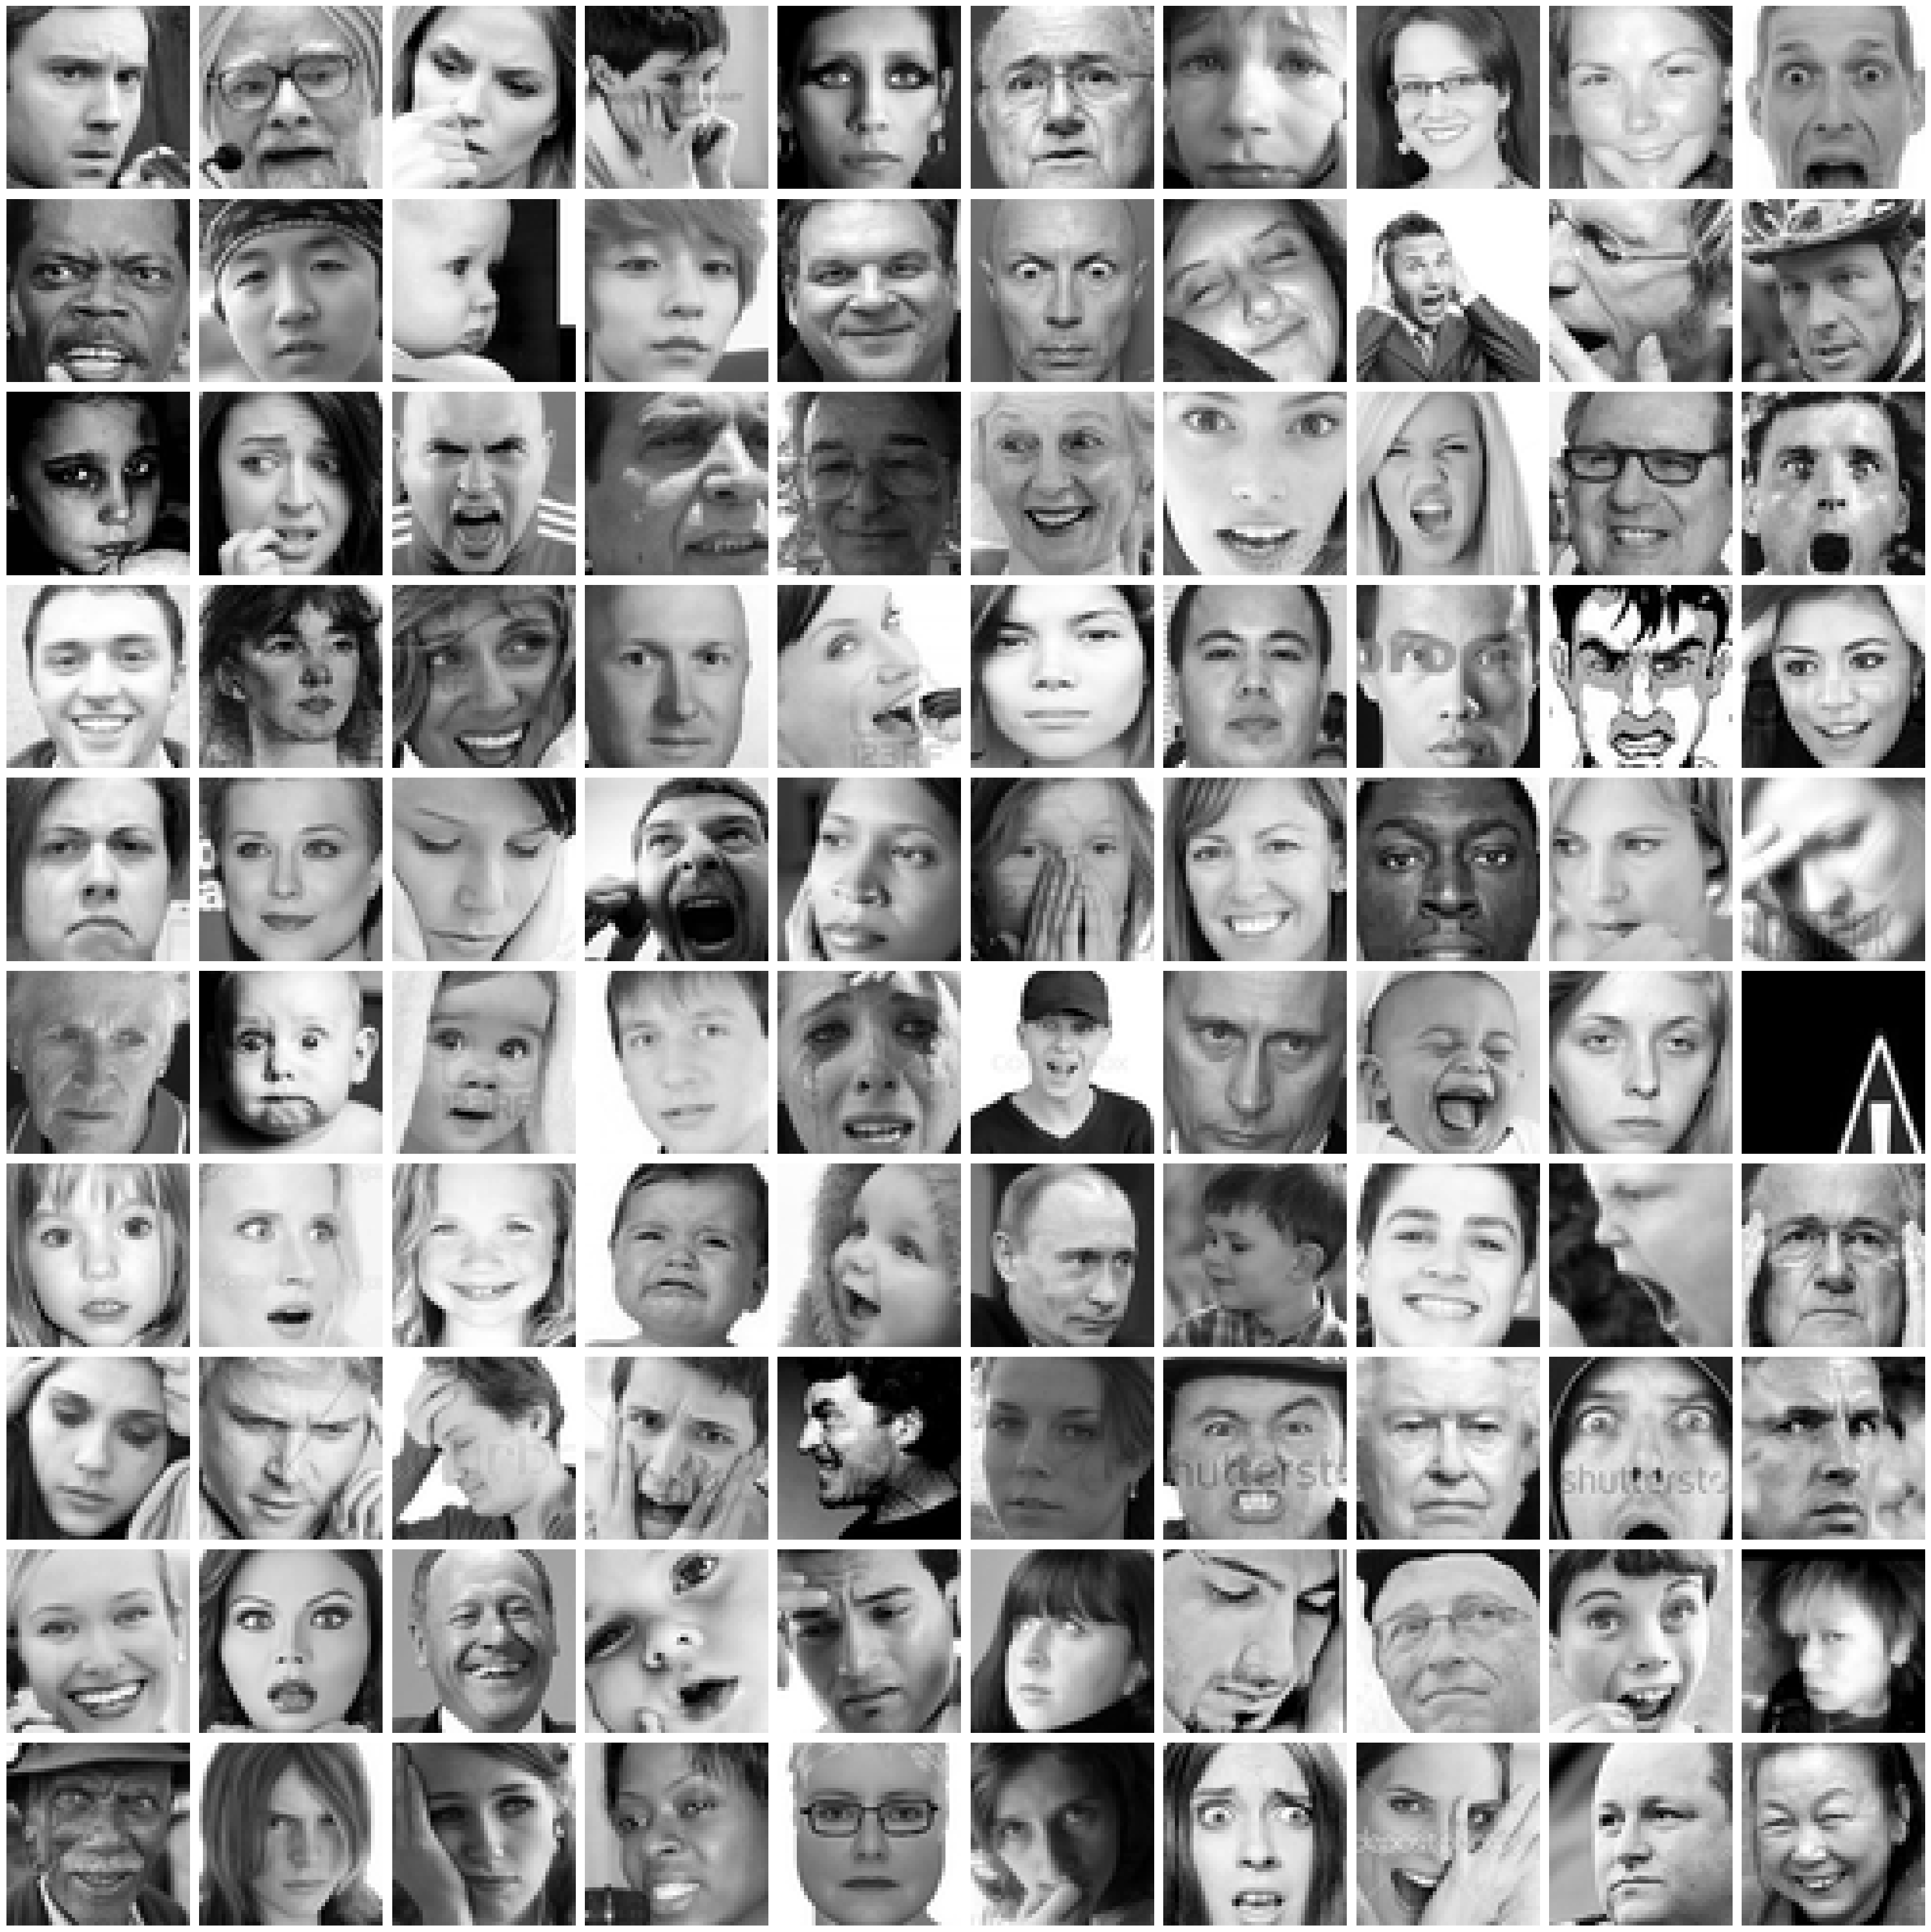

In [ ]:
display_faces(data, 100)

In [ ]:
overfit_train=data[:16]
overfit_val=data[16:32]
overfit_test=data[32:48]
train=data.sample(frac=0.8,random_state=42)
val=data.drop(train.index).sample(frac=0.5, random_state=42)
test=data.drop(train.index).drop(val.index)

In [ ]:
overfit_train.shape, overfit_val.shape, overfit_test.shape, train.shape , val.shape , test.shape

((16, 2), (16, 2), (16, 2), (22967, 2), (2871, 2), (2871, 2))

In [ ]:
def compute_mean_image(dataframe, image_shape=(48, 48)):
  """
  Computes the mean image from a DataFrame containing image pixel data.

  Args:
    dataframe: A pandas DataFrame with a 'pixels' column containing space-separated
               string representations of pixel values.
    image_shape: A tuple representing the shape of each image (height, width).

  Returns:
    A NumPy array representing the mean image.
  """
  all_images = []
  for pixel_string in tqdm(dataframe['pixels'], desc="Computing mean image"):
    pixel_list = [int(pixel) for pixel in pixel_string.split()]
    image_array = np.array(pixel_list).reshape(image_shape)
    all_images.append(image_array)

  all_images = np.array(all_images)
  return all_images.mean(axis=0), all_images.std(axis=0)

In [ ]:
train_mean_image, train_std = compute_mean_image(train)
val_mean_image, _ = compute_mean_image(val)
test_mean_image, _ = compute_mean_image(test)

Computing mean image: 100%|██████████| 2871/2871 [00:01<00:00, 2277.15it/s]


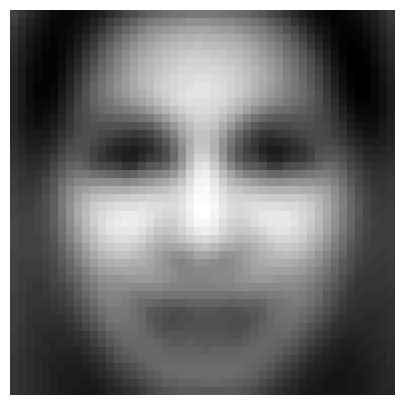

In [ ]:
display_image(train_mean_image)

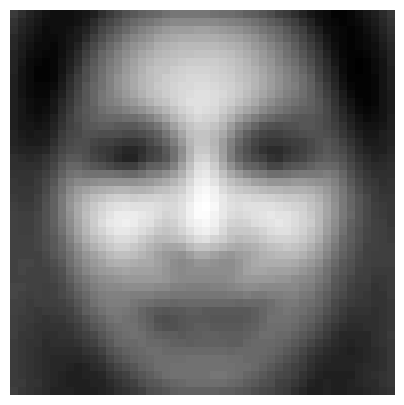

In [ ]:
display_image(val_mean_image)

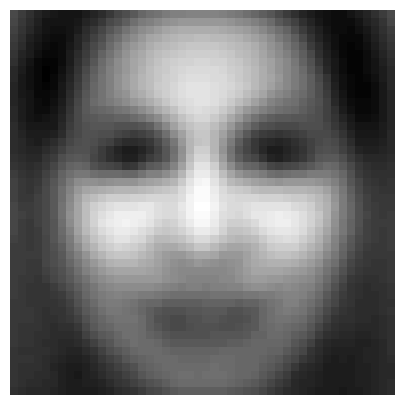

In [ ]:
display_image(test_mean_image)

In [ ]:
train_mean_image

array([[120.18739931, 117.1484739 , 114.10040493, ..., 112.98554448,
        115.87965342, 118.76588148],
       [119.03979623, 115.86841991, 112.9715679 , ..., 111.98245308,
        114.99416554, 117.84107633],
       [117.66874211, 114.54055819, 111.77271738, ..., 110.92711281,
        113.94971045, 116.8515261 ],
       ...,
       [117.33596029, 116.34397179, 115.32468324, ..., 112.29237602,
        113.10471546, 114.07563025],
       [117.34061915, 116.35977707, 115.34436365, ..., 112.39796229,
        113.09343841, 114.0262986 ],
       [117.30526407, 116.3100971 , 115.15940262, ..., 112.43810685,
        113.09518004, 113.90138024]])

# Preprocess

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean_image / 256, 1.0),
])

In [ ]:
class FacialExpressionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # process label
        label = int(self.dataframe.iloc[idx]['emotion'])
        label = torch.tensor(label, dtype=torch.long)

        # process image
        img_pixels = self.dataframe.iloc[idx]['pixels']
        pixel_list = [int(pixel) for pixel in img_pixels.split()]
        image_array = np.array(pixel_list).reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(image_array, mode='L')

        # transform image
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def to_loader(dataframe, transform, batch_size=16):
  dataset = FacialExpressionDataset(dataframe, transform)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return loader

In [ ]:
dataset = FacialExpressionDataset(data, transform)

In [ ]:
for i in range(10):
  image_tensor = dataset.__getitem__(i)[0]
  image_pixels = image_tensor.squeeze(0)
  pixels_greater_than_zero = (image_pixels > 0).sum().item()

  print(f"Number of pixels greater than 0: {pixels_greater_than_zero} | {(pixels_greater_than_zero / (48 * 48) * 100)}%")

Number of pixels greater than 0: 1079 | 46.83159722222222%
Number of pixels greater than 0: 1192 | 51.736111111111114%
Number of pixels greater than 0: 1635 | 70.96354166666666%
Number of pixels greater than 0: 1385 | 60.11284722222222%
Number of pixels greater than 0: 786 | 34.11458333333333%
Number of pixels greater than 0: 1302 | 56.510416666666664%
Number of pixels greater than 0: 1121 | 48.65451388888889%
Number of pixels greater than 0: 928 | 40.27777777777778%
Number of pixels greater than 0: 1782 | 77.34375%
Number of pixels greater than 0: 1887 | 81.90104166666666%


In [ ]:
dataset.__getitem__(10)[0]

tensor([[[-0.3518, -0.3635, -0.3634,  ..., -0.2963, -0.2801, -0.3188],
         [-0.3434, -0.3663, -0.3589,  ..., -0.2923, -0.3119, -0.2995],
         [-0.3538, -0.3611, -0.3621,  ..., -0.3039, -0.3118, -0.2996],
         ...,
         [-0.3446, -0.3407, -0.3485,  ...,  0.0241,  0.0758,  0.1348],
         [-0.3407, -0.3369, -0.3447,  ...,  0.1649,  0.1818,  0.2056],
         [-0.3327, -0.3406, -0.3400,  ...,  0.2353,  0.2367,  0.2335]]])

# Model

In [ ]:
class BaseNN(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.ModuleList()

    conv_layers = config['conv_layers']
    hidden_dims = config['hidden_dims']
    normalization = config['normalization']
    dropout = config['dropout']
    self.residual = config['residual']

    fc_dim = 48
    last_channel = 1

    for conv in conv_layers:
      if len(conv) == 5:
        fc_dim = (fc_dim - (conv[2]-1) + 2 * conv[3] - 1) // conv[4] + 1
        last_channel = conv[1]
        # Conv Layer
        self.layers.append(nn.Conv2d(conv[0], conv[1], kernel_size=conv[2], padding=conv[3], stride=conv[4]))
        # Normalization
        if config['c-normalization'] == 'batch':
          self.layers.append(nn.BatchNorm2d(conv[1]))
        # Activation
        if config['activation'] == 'leaky':
          self.layers.append(nn.LeakyReLU())
        else:
          self.layers.append(nn.ReLU())
      elif len(conv) == 2:
        fc_dim = ((fc_dim - conv[0]) // conv[1]) + 1
        # Pooling
        self.layers.append(nn.MaxPool2d(kernel_size=conv[0], stride=conv[1]))

    self.layers.append(nn.Flatten())

    dims = [fc_dim * fc_dim * last_channel] + hidden_dims + [7]

    l = len(dims)
    for i in range(l-2):
      # Linear
      self.layers.append(nn.Linear(dims[i], dims[i+1]))
      # Normalization
      if normalization == 'batch':
        self.layers.append(nn.BatchNorm1d(dims[i+1]))
      elif normalization == 'layer':
        self.layers.append(nn.LayerNorm(dims[i+1]))
      # Activation
      if config['activation'] == 'leaky':
        self.layers.append(nn.LeakyReLU())
      else:
        self.layers.append(nn.ReLU())
      # Dropout
      if dropout > 0:
        self.layers.append(nn.Dropout(dropout))
    self.layers.append(nn.Linear(dims[l-2], dims[l-1]))

  def forward(self, x):
    for layer in self.layers:
      x_c = x
      x = layer(x)
      # Residual
      if self.residual and (isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU)):
        x += x_c
    return x

In [ ]:
def get_model(config):
  return BaseNN(config).to(device)

In [ ]:
config = {
    'learning_rate': 1e-3,
    'epochs': 10,
    'weight_decay': 0.0,
    'batch_size': 16,
    'hidden_dims': [1024],
    'normalization': 'none',
    'dropout': 0.0,
    'architecture': 'Simple NN'
}

In [ ]:
model = get_model(config)

In [ ]:
summary(model, input_size = (1, 48, 48), device=device)

# Training Definitions

In [ ]:
import torch
import time

def train_model(
    model,
    data,
    criterion,
    optimizer,
    num_epochs=10,
    device='cuda',
    print_report=True,
    log_wandb=False):

    train_loader = data['train']
    val_loader = data['val']

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'grad_to_weight_ratio': [],
        'weight_norm': []
    }

    model.to(device)

    # scheduler = ExponentialLR(optimizer, gamma=0.98)

    for epoch in range(num_epochs):
        start_time = time.time()

        # ---- TRAINING ----
        model.train()

        # important training metrics
        running_loss = 0.0
        correct = 0
        total = 0

        # gadient to weight ration metrics
        total_grad = 0.0
        total_weight = 0.0
        current_grad_ratio = 0.0
        total_grad_ratio = []
        avg_grad_ratio = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            # data to gpu
            images, labels = images.to(device), labels.to(device)
            # reset grad
            optimizer.zero_grad()

            # forward
            outputs = model(images)
            # calculate loss
            loss = criterion(outputs, labels)
            # backward (calculate grads)
            loss.backward()

            # grad-to-weight ration calculation
            for param in model.parameters():
                if param.grad is not None:
                    total_grad += param.grad.norm().item()
                    total_weight += param.data.norm().item()

            if total_weight > 0:
                current_grad_ratio = (total_grad / total_weight) * 100
            else:
                current_grad_ratio = 0.0

            total_grad_ratio.append(current_grad_ratio)

            # update
            optimizer.step()

            # calculate loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if print_report and batch_idx % 200 == 0:
                # print batch info to output
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Batch {batch_idx}/{len(train_loader)} - "
                      f"Loss: {loss.item():.4f} - "
                      f"Processed: {total} images - "
                      f"Grad_to_weight_ratio: {current_grad_ratio:.2%}")
            # if print_report and batch_idx % 400 == 0:
            #     # print gradient mean to see that it's being changed
            #     for i, layer in enumerate(model.layers):
            #         if hasattr(layer, 'weight'):
            #             grad = layer.weight.grad
            #             if grad is not None:
            #                 print(f"Layer {i} ({layer}): grad mean = {grad.mean().item():.6f}")
            #             else:
            #                 print(f"Layer {i} ({layer}): grad = None")

        # calculate training metrics
        train_loss = running_loss / total
        train_acc = correct / total
        avg_grad_ratio = sum(total_grad_ratio) / len(total_grad_ratio)

        # ---- VALIDATION ----
        model.eval()

        # important validation metrics
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            # validate for batches
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # calculate full epoch (training + validation) time
        epoch_time = time.time() - start_time

        # calculate validation metrics
        val_loss /= val_total
        val_acc = val_correct / val_total
        weight_norm = sum(p.data.norm().item() for p in model.parameters())

        # save metrics to history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['grad_to_weight_ratio'].append(avg_grad_ratio)
        history['weight_norm'].append(weight_norm)

        # scheduler.step()

        if print_report:
            # print epoch report
            print(f"\nEpoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.1f}s")
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
            print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2%}")
            print(f"Grad to Weight Ratio: {avg_grad_ratio:.2%}")
            print(f"Weight Norm: {weight_norm:.2f}\n")
        if log_wandb:
            # log epoch to wandb
            metrics = {
                f"epoch": epoch + 1,
                f"train_loss": train_loss,
                f"val_loss": val_loss,
                f"train_acc": train_acc,
                f"val_acc": val_acc,
                f"grad_ratio": avg_grad_ratio,
                f"weight_norm": weight_norm,
                f"epoch_time": epoch_time
            }

            if epoch > 0:
                # log graphs to wandb
                loss_data = [[x, history['train_loss'][x], history['val_loss'][x]]
                             for x in range(epoch + 1)]
                acc_data = [[x, history['train_acc'][x], history['val_acc'][x]]
                            for x in range(epoch + 1)]

                metrics.update({
                    f"loss_plot": wandb.plot.line_series(
                        xs=range(epoch + 1),
                        ys=[history['train_loss'], history['val_loss']],
                        keys=["Train", "Val"],
                        title="Loss Progress",
                        xname="Epoch"
                    ),
                    f"acc_plot": wandb.plot.line_series(
                        xs=range(epoch + 1),
                        ys=[history['train_acc'], history['val_acc']],
                        keys=["Train", "Val"],
                        title="Accuracy Progress",
                        xname="Epoch"
                    ),
                    "grad_plot": wandb.plot.line(
                        wandb.Table(
                            data=[[x, y] for x, y in zip(range(epoch + 1), history['grad_to_weight_ratio'])],
                            columns=["Epoch", "Grad/Weight Ratio"]
                        ),
                        "Epoch",  # x-axis
                        "Grad/Weight Ratio",  # y-axis
                        title="Gradient-to-Weight Ratio Over Time"
                    )
                })

            wandb.log(metrics)

    return history


# Training

In [ ]:
def make(config):
  model = get_model(config)
  if config['optimizer'] == 'sgd_mom':
    optimizer = SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'], weight_decay=config['weight_decay'])
  elif config['optimizer'] == 'adagrad':
    optimizer = Adagrad(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
  elif config['optimizer'] == 'rmsprop':
    optimizer = RMSprop(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
  else:
    optimizer = Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
  criterion = nn.CrossEntropyLoss()

  training_data = {
      'train': to_loader(train, transform=transform, batch_size=config['batch_size']),
      'val': to_loader(val, transform=transform, batch_size=config['batch_size']),
      'test': to_loader(test, transform=transform, batch_size=config['batch_size']),
      'overfit_train': to_loader(overfit_train, transform=transform, batch_size=config['batch_size']),
      'overfit_val': to_loader(overfit_val, transform=transform, batch_size=config['batch_size']),
      'overfit_test': to_loader(overfit_test, transform=transform, batch_size=config['batch_size']),
  }

  return model, training_data, criterion, optimizer


In [ ]:
def overfit(config):
  model, data, criterion, optimizer = make(config)

  data['train'] = data['overfit_train']
  data['val'] = data['overfit_val']
  data['test'] = data['overfit_test']

  return train_model(model, data, criterion, optimizer, 100, device, False, False)

In [ ]:
overfit_history = overfit(config)

In [ ]:
model, training_data, criterion, optimizer = make(config)

history = train_model(model, training_data, criterion, optimizer, 3, device, True)

# Testing Definitions

In [ ]:
def test_model(model, test_loader, criterion=None, device='cpu', print_report=True, log_wandb=False):
    # evaluate model
    model.eval()

    # metrics
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        # go over batches
        for inputs, labels in test_loader:
            # push data to gpu
            inputs, labels = inputs.to(device), labels.to(device)

            # evaluate data
            outputs = model(inputs)

            # calculate loss
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)

            # calculate metrics
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())

    accuracy = total_correct / total_samples
    results = {
        'accuracy': accuracy,
        'true_labels': np.array(true_labels),
        'pred_labels': np.array(pred_labels)
    }

    if criterion is not None:
        results['loss'] = total_loss / total_samples

    present_labels = np.unique(true_labels)
    clf_report = classification_report(
        true_labels, pred_labels,
        labels=present_labels,
        zero_division=0,
        output_dict=True
    )

    if print_report:
        # print reports to output
        print(f"Test Accuracy: {accuracy:.4f}")
        if criterion is not None:
            print(f"Test Loss: {results['loss']:.4f}")

        # Handle cases where some classes are missing in predictions
        present_labels = np.unique(true_labels)
        print("\nClassification Report (subset of classes present in test set):")
        print(classification_report(
            true_labels,
            pred_labels,
            labels=present_labels,
            zero_division=0  # Silences the warning by defining 0/0 = 0
        ))

        print("\nConfusion Matrix (subset):")
        print(confusion_matrix(true_labels, pred_labels, labels=present_labels))
    if log_wandb:
        # log metrics to wandb
        wandb.log(results)

        for label in present_labels:
            label = str(label)
            wandb.log({
                f'test/precision_{label}': clf_report[label]['precision'],
                f'test/recall_{label}': clf_report[label]['recall'],
                f'test/f1_{label}': clf_report[label]['f1-score'],
            })

        wandb.log({
            "confusion_matrix": wandb.plot.confusion_matrix(
                y_true=true_labels,
                preds=pred_labels,
                class_names=[str(x) for x in present_labels]
            )
        })

    return results

In [ ]:
test_model(model, training_data['test'], criterion, device)

# Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, is_overfit=False):
    """
    Plots training and validation loss, accuracy, gradient-to-weight ratio, and weight norm.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(24, 5))

    # ---- LOSS ----
    plt.subplot(1, 4, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # ---- ACCURACY ----
    plt.subplot(1, 4, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val Acc', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # ---- GRADIENT-TO-WEIGHT RATIO ----
    plt.subplot(1, 4, 3)
    plt.plot(epochs, history['grad_to_weight_ratio'], label='Grad/Weight Ratio', marker='o', color='purple')
    plt.title('Grad-to-Weight Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio (%)')
    plt.legend()
    plt.grid(True)

    # ---- WEIGHT NORM ----
    plt.subplot(1, 4, 4)
    plt.plot(epochs, history['weight_norm'], label='Weight Norm', marker='o', color='darkgreen')
    plt.title('Weight Norm over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Norm (L2)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"training_plot{'_overfit' if is_overfit else ''}.png")
    plt.show()


In [ ]:
plot_training_history(overfit_history)

# Model Pipeline

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dachis (dachis-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
config = {
    'learning_rate': 1e-3,
    'weight_decay': 1e-3,
    'optimizer': 'adam',
    'momentum': 0.0,
    'epochs': 20,
    'batch_size': 256,
    'conv_layers': [
        (1, 32, 5, 2, 1),
        (2, 2),
        (32, 64, 5, 2, 1),
        (2, 2),
        (64, 128, 5, 2, 1),
        (2, 2),
    ],
    'pooling': 'max',
    'hidden_dims': [1024, 512],
    'c-normalization': 'batch',
    'normalization': 'layer',
    'dropout': 0.5,
    'activation': 'none',
    'residual': False,
    'architecture': '3-2-Up-Maxpool-Dropout-Layernorm-CBatchnorm-CNN'
}

In [ ]:
def wandb_run():
    with wandb.init(
        project='emotion-recognition',
        config=config,
        name=config['architecture']+'-20-epoch',
        tags=['3-2-layer', 'cnn', 'up-down', 'maxpool', 'dropout', 'layernorm', 'c-batchnorm']):
      overfit_history = overfit(config)
      plot_training_history(overfit_history, True)

      wandb.log({"Overfit Training Curves": wandb.Image("training_plot_overfit.png")})

      print('\ntraining\n')

      model, training_data, criterion, optimizer = make(config)
      summary(model, input_size = (1, 48, 48), device=device)

      wandb.watch(model, criterion, log='all', log_freq=10)
      history = train_model(model, training_data, criterion, optimizer, config['epochs'], device, True, True)
      plot_training_history(history)

      test_model(model, training_data['test'], criterion, device, True, True)

      wandb.log({"Training Curves": wandb.Image("training_plot.png")})

      torch.save(model.state_dict(), config['architecture'] + '.pt')
      wandb.save(config['architecture'] + '.pt')  # upload to W&B


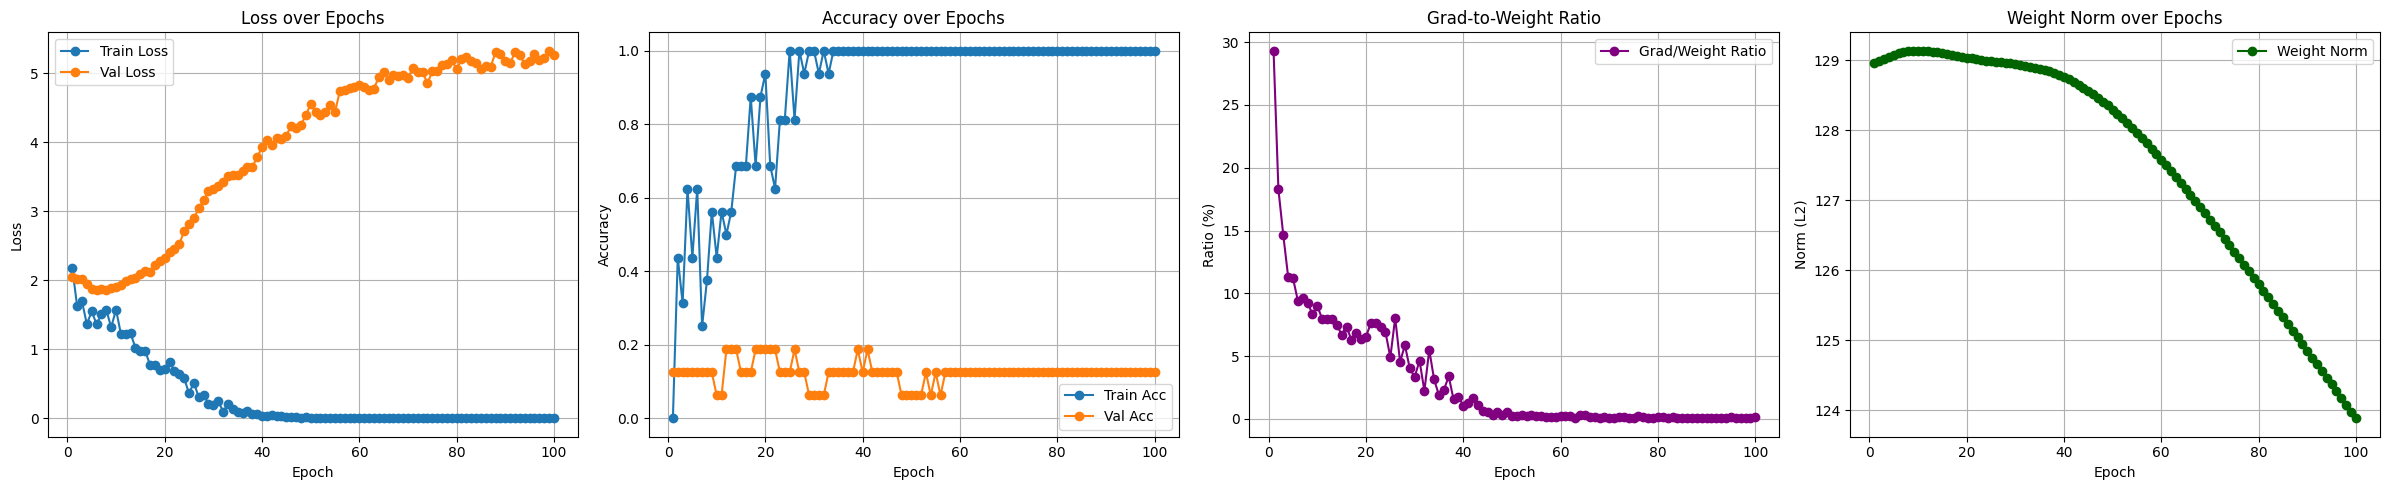


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

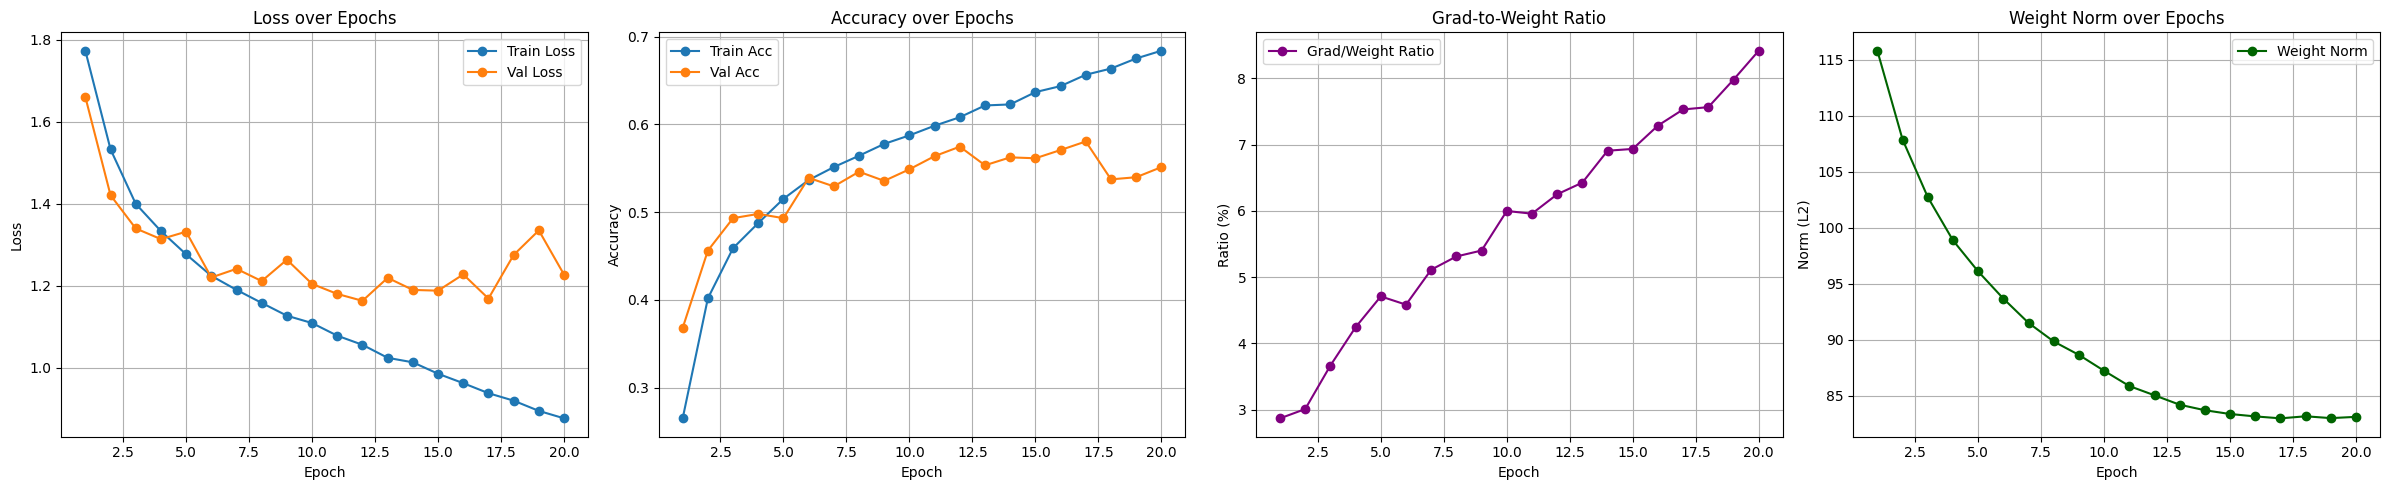

Test Accuracy: 0.5486
Test Loss: 1.2549

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.45      0.51      0.48       385
           1       0.57      0.08      0.14        49
           2       0.41      0.37      0.39       432
           3       0.79      0.76      0.78       705
           4       0.36      0.62      0.46       456
           5       0.78      0.65      0.71       331
           6       0.61      0.36      0.45       513

    accuracy                           0.55      2871
   macro avg       0.57      0.48      0.49      2871
weighted avg       0.58      0.55      0.55      2871


Confusion Matrix (subset):
[[197   1  38  29  92   5  23]
 [ 17   4  13   2  13   0   0]
 [ 56   2 161  19 123  33  38]
 [ 29   0  36 535  73  10  22]
 [ 59   0  52  27 281   5  32]
 [ 12   0  57  21  24 214   3]
 [ 69   0  40  42 170   9 183]]


In [ ]:
wandb_run()

# Sweep

Create sweep with ID: 3a7jptiy
Sweep URL: https://wandb.ai/dachis-none/emotion-recognition/sweeps/3a7jptiy


wandb: Agent Starting Run: cvrriaee with config:
wandb: 	batch_size: 256
wandb: 	conv_layers: [[1, 32, 5, 2, 1], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 5, 2, 1], [2, 2]]
wandb: 	dropout: 0.5654275590526225
wandb: 	learning_rate: 0.0013946315749581203
wandb: 	weight_decay: 0.00912238990589778


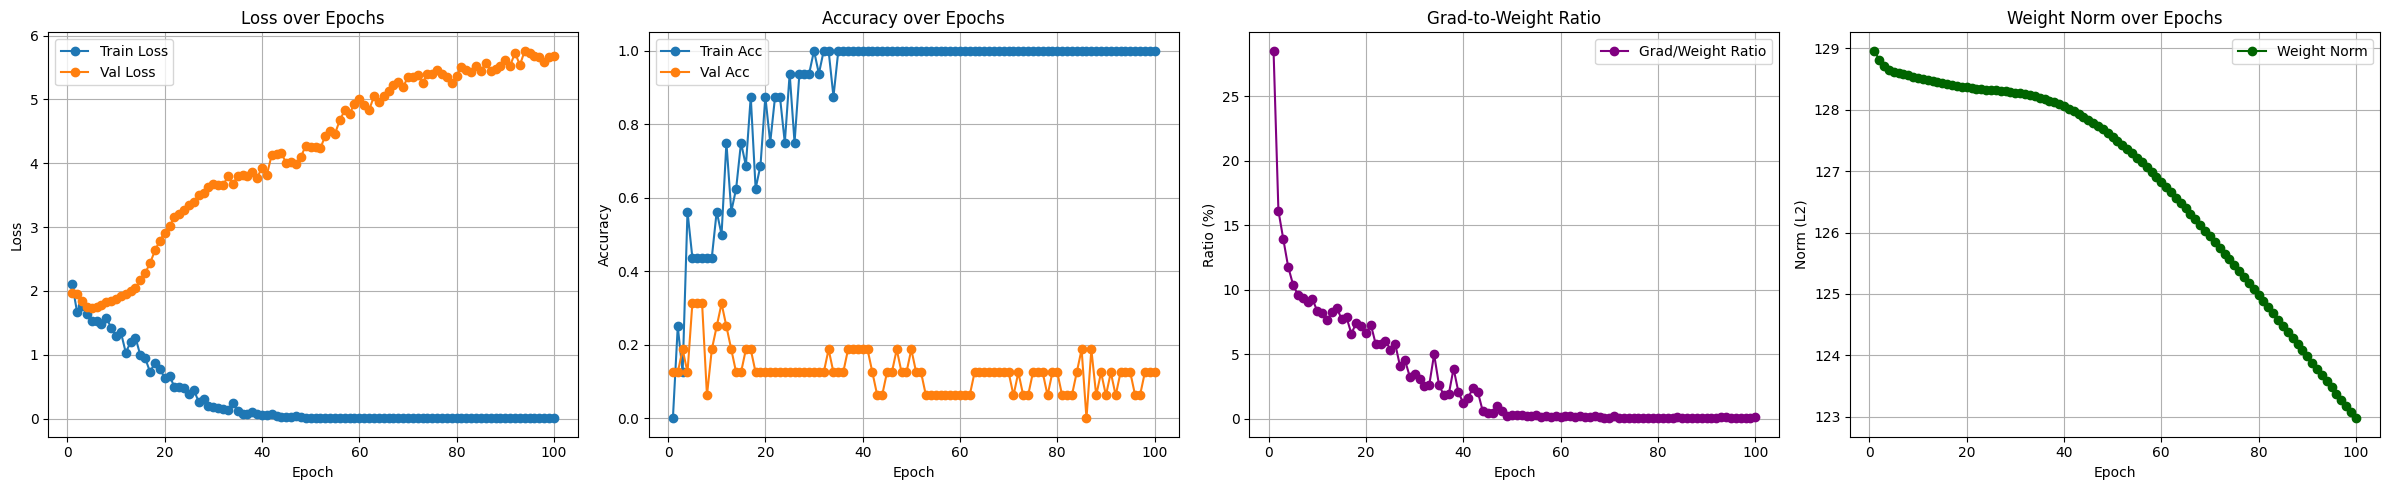


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

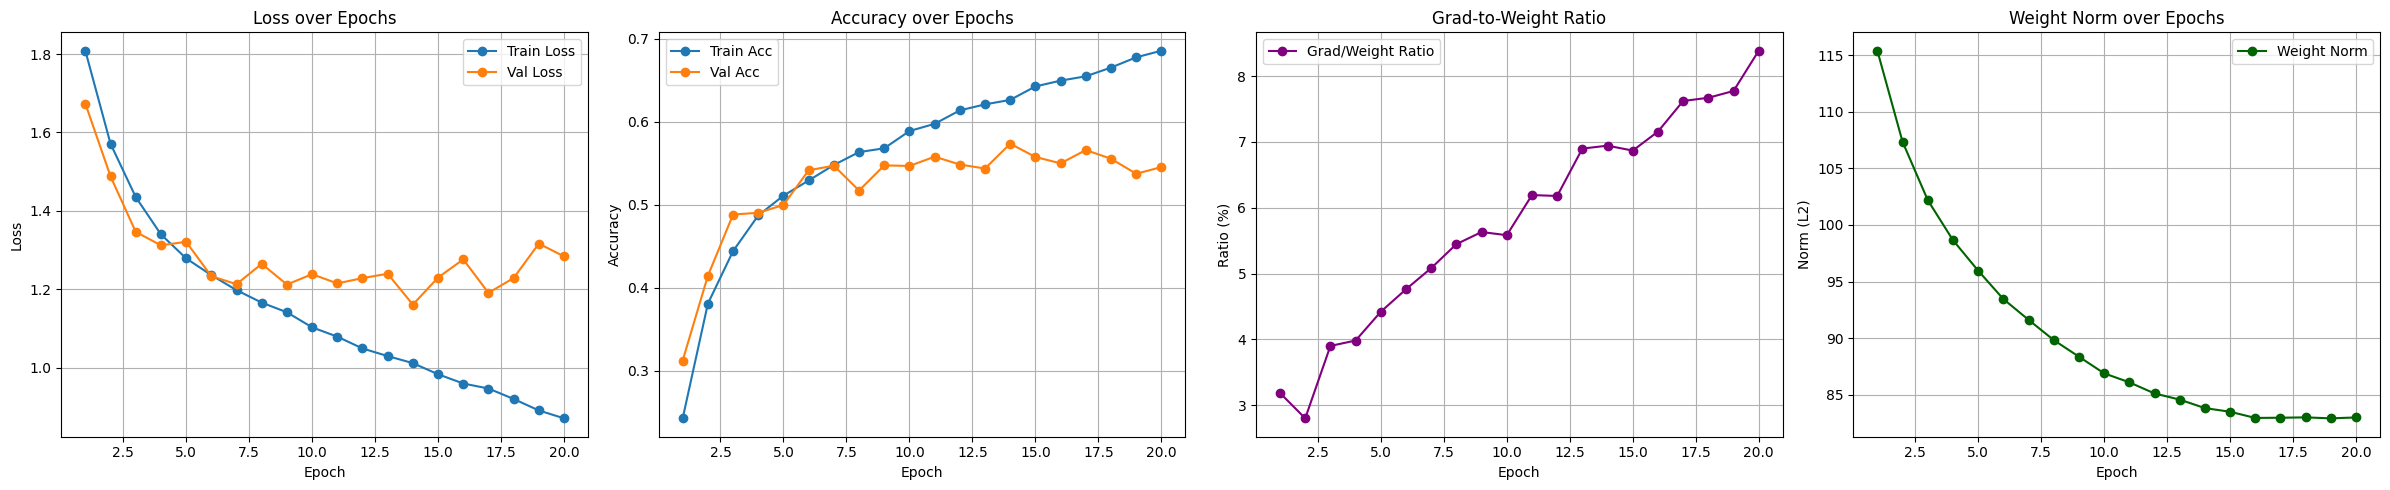

Test Accuracy: 0.5587
Test Loss: 1.2841

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       385
           1       0.64      0.14      0.23        49
           2       0.40      0.29      0.33       432
           3       0.72      0.82      0.77       705
           4       0.47      0.29      0.36       456
           5       0.59      0.80      0.68       331
           6       0.50      0.60      0.55       513

    accuracy                           0.56      2871
   macro avg       0.54      0.49      0.49      2871
weighted avg       0.54      0.56      0.54      2871


Confusion Matrix (subset):
[[189   1  36  40  29  22  68]
 [ 18   7   7   4   8   1   4]
 [ 49   1 125  42  62  83  70]
 [ 22   0  25 579  12  24  43]
 [ 69   1  76  48 133  25 104]
 [  8   0  15  26   2 264  16]
 [ 42   1  32  67  38  26 307]]


wandb: Agent Starting Run: yk9b5rc8 with config:
wandb: 	batch_size: 512
wandb: 	conv_layers: [[1, 32, 5, 2, 1], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 5, 2, 1], [2, 2]]
wandb: 	dropout: 0.4800964819844686
wandb: 	learning_rate: 0.002134547173990031
wandb: 	weight_decay: 0.00670712151462187


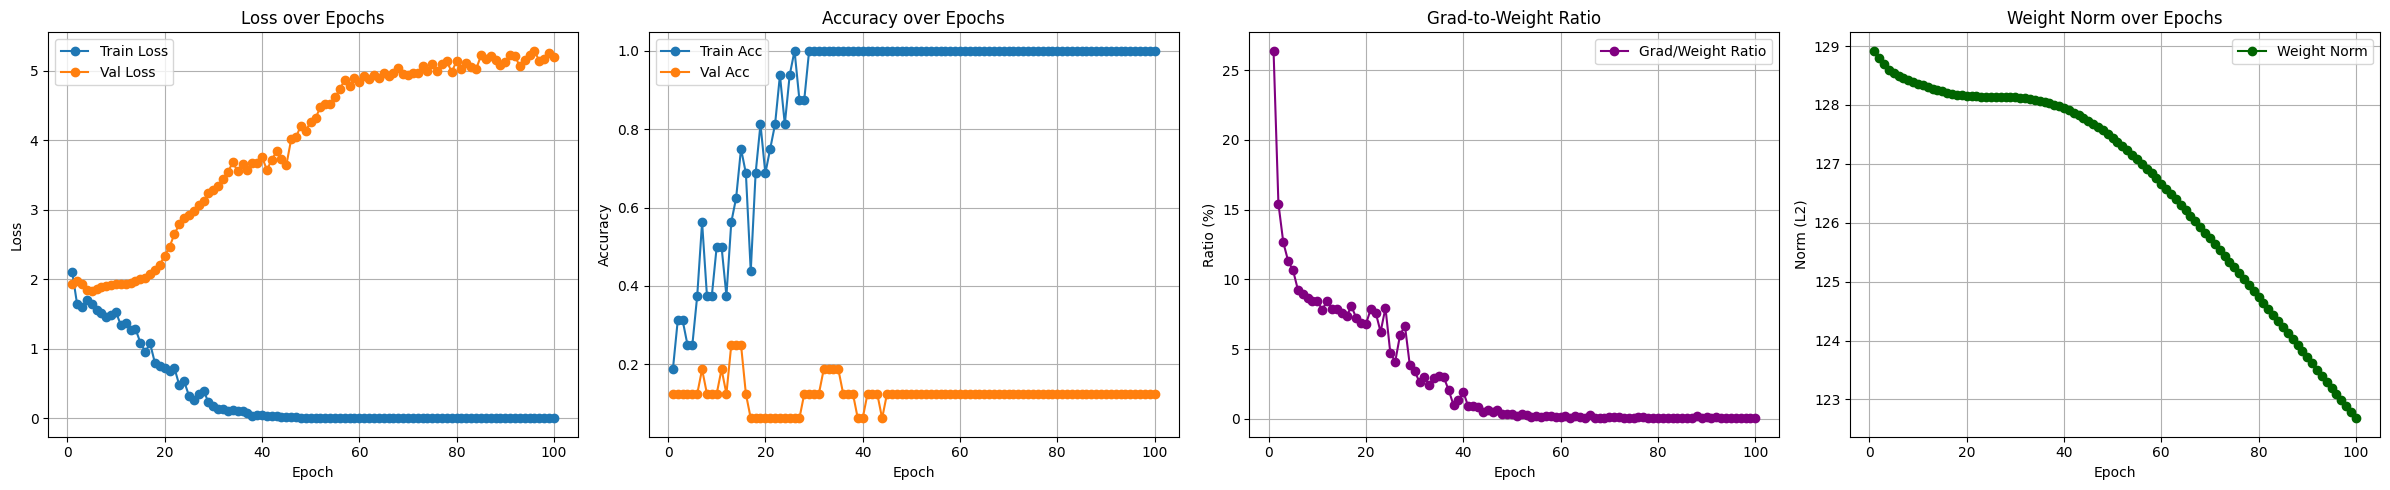


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

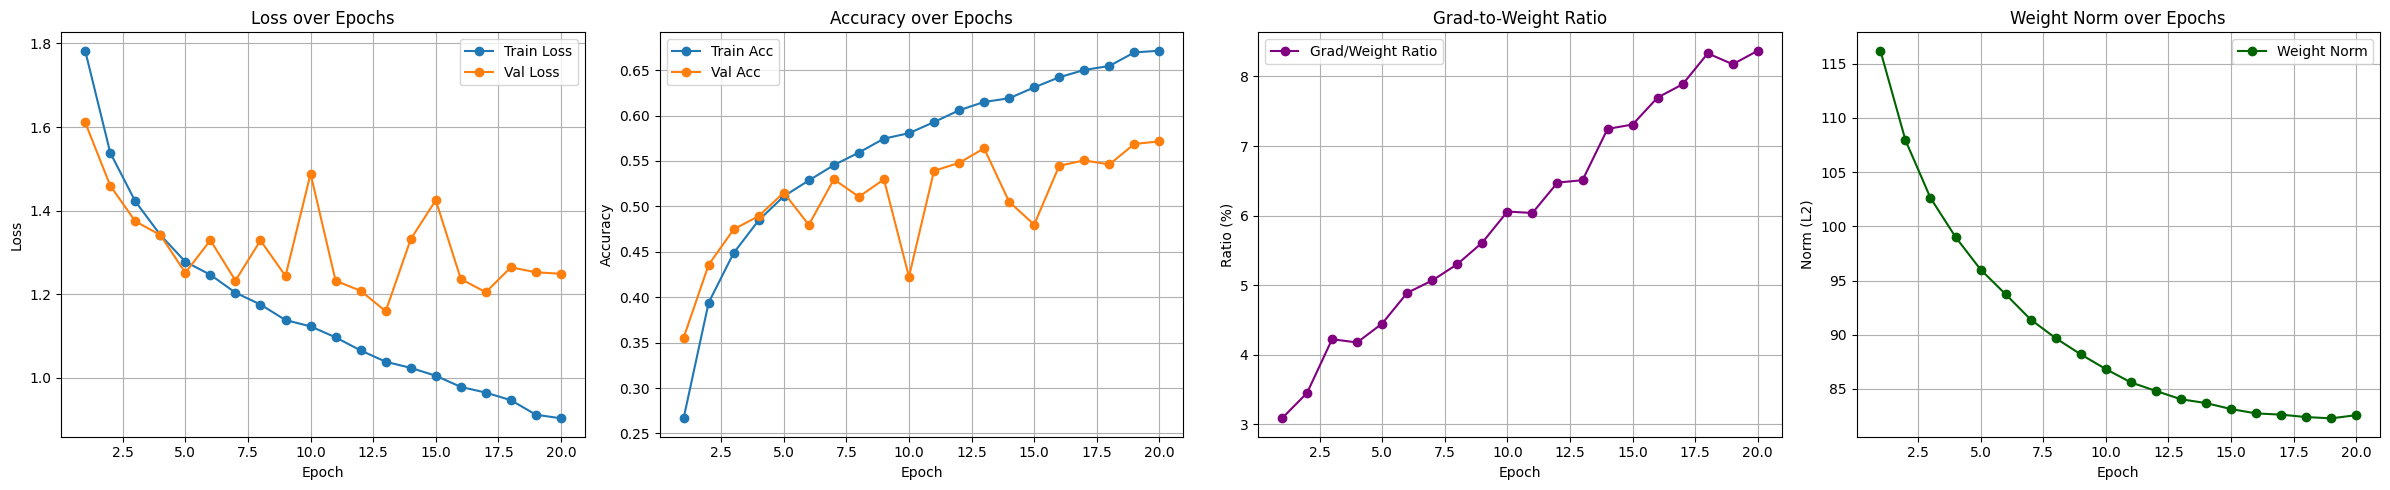

Test Accuracy: 0.5632
Test Loss: 1.3087

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.54      0.34      0.42       385
           1       0.42      0.10      0.16        49
           2       0.45      0.28      0.34       432
           3       0.70      0.81      0.75       705
           4       0.44      0.44      0.44       456
           5       0.71      0.73      0.72       331
           6       0.47      0.67      0.55       513

    accuracy                           0.56      2871
   macro avg       0.53      0.48      0.48      2871
weighted avg       0.56      0.56      0.55      2871


Confusion Matrix (subset):
[[130   1  33  66  61   5  89]
 [ 11   5   7   6  12   2   6]
 [ 37   3 120  35  84  61  92]
 [ 12   0  15 573  29  18  58]
 [ 31   1  48  45 202   5 124]
 [  6   1  18  35  11 243  17]
 [ 12   1  25  60  63   8 344]]


wandb: Agent Starting Run: rdxibqkz with config:
wandb: 	batch_size: 128
wandb: 	conv_layers: [[1, 32, 7, 3, 2], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 3, 1, 1], [2, 2]]
wandb: 	dropout: 0.3544721740102715
wandb: 	learning_rate: 0.0976222643882483
wandb: 	weight_decay: 0.004552734118123967


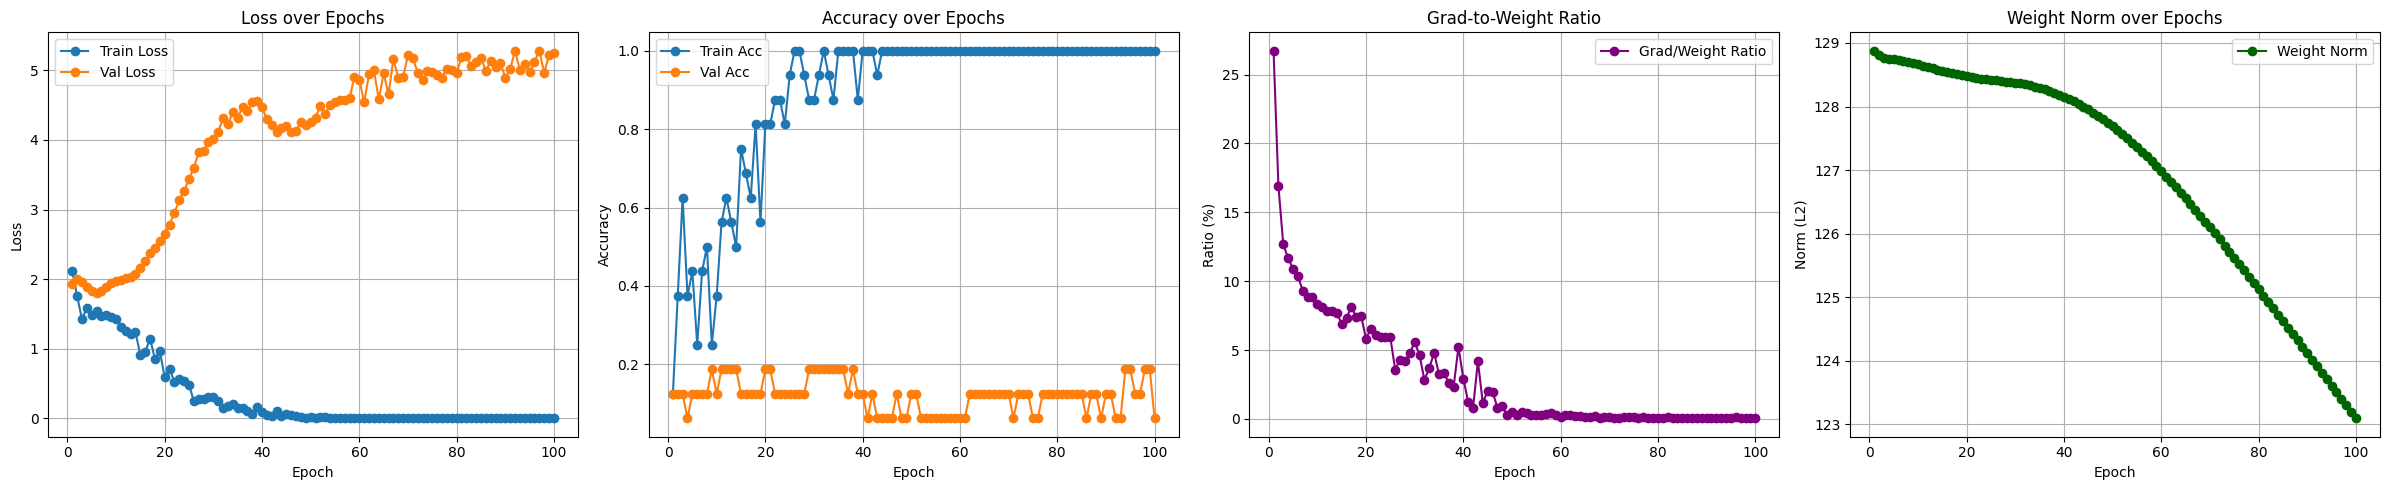


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

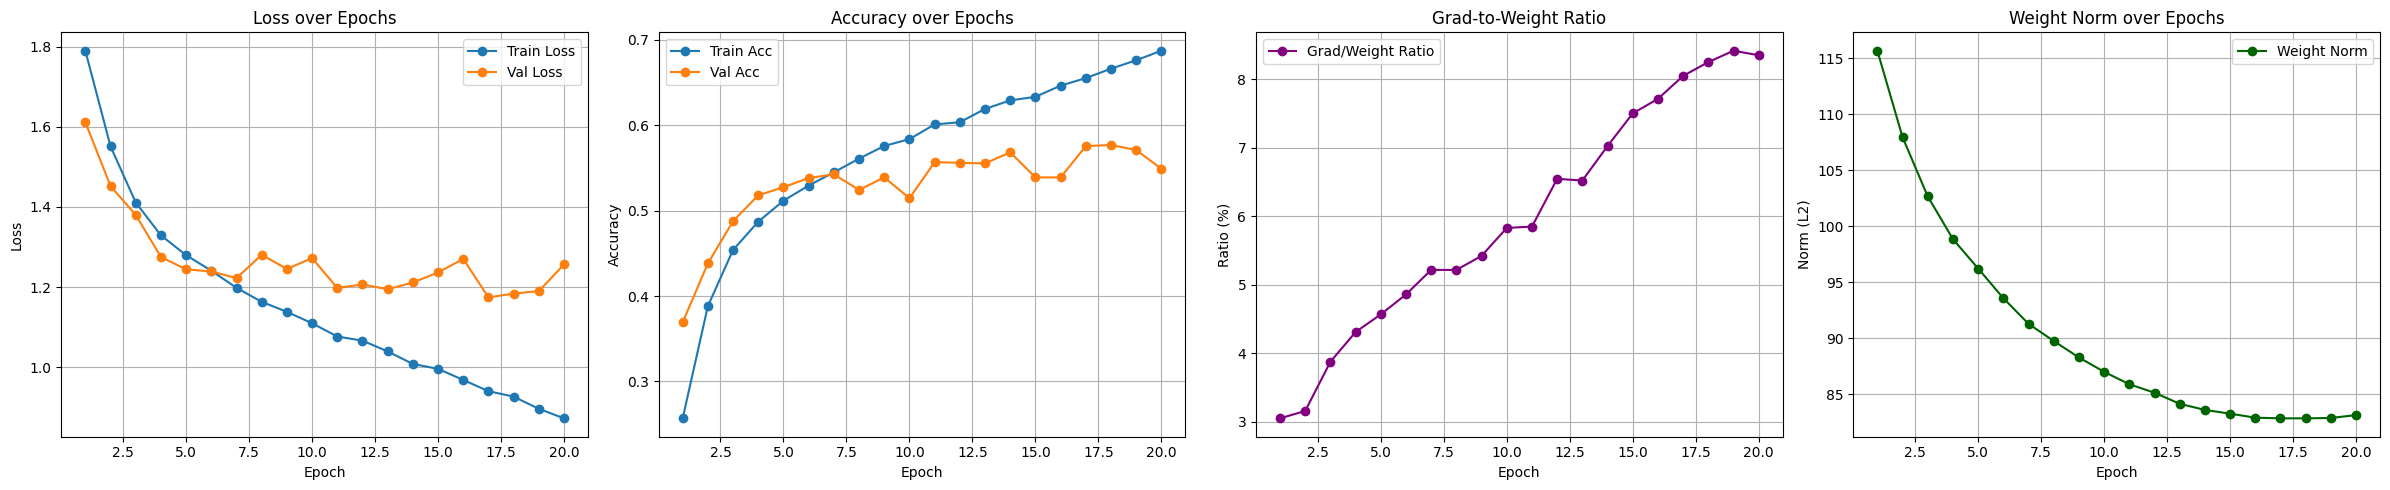

Test Accuracy: 0.5350
Test Loss: 1.3274

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.34      0.68      0.45       385
           1       1.00      0.06      0.12        49
           2       0.48      0.25      0.33       432
           3       0.74      0.74      0.74       705
           4       0.44      0.47      0.45       456
           5       0.71      0.68      0.70       331
           6       0.55      0.39      0.46       513

    accuracy                           0.54      2871
   macro avg       0.61      0.47      0.46      2871
weighted avg       0.57      0.54      0.53      2871


Confusion Matrix (subset):
[[261   0  15  34  42   6  27]
 [ 34   3   0   4   5   1   2]
 [120   0 108  39  76  46  43]
 [ 76   0  14 522  34  20  39]
 [132   0  29  33 214   8  40]
 [ 24   0  33  19  16 226  13]
 [119   0  25  54 102  11 202]]


wandb: Agent Starting Run: c0uog4sw with config:
wandb: 	batch_size: 256
wandb: 	conv_layers: [[1, 32, 5, 2, 1], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 5, 2, 1], [2, 2]]
wandb: 	dropout: 0.42755023053638064
wandb: 	learning_rate: 0.052712462862934246
wandb: 	weight_decay: 0.0007339490640287183


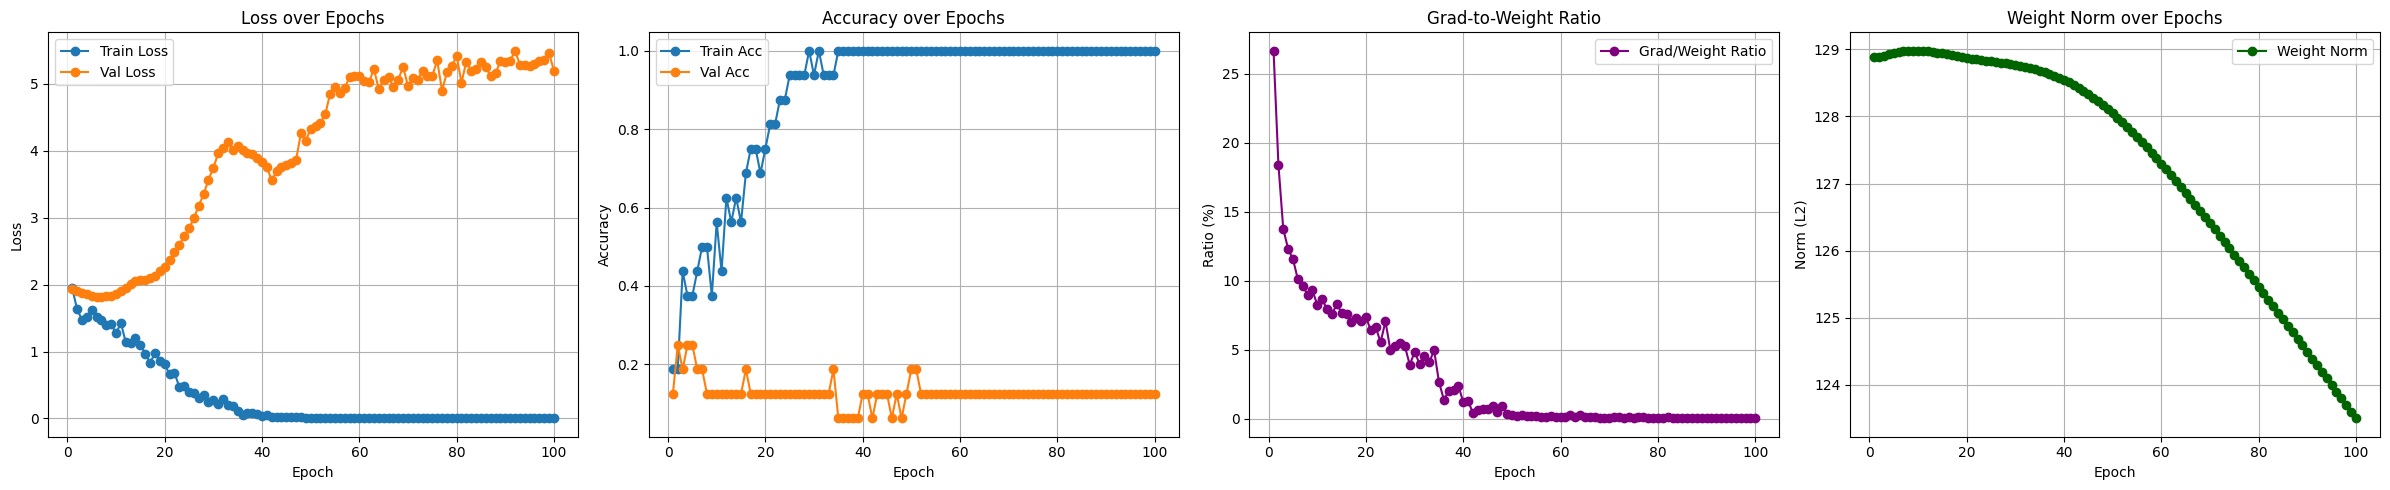


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

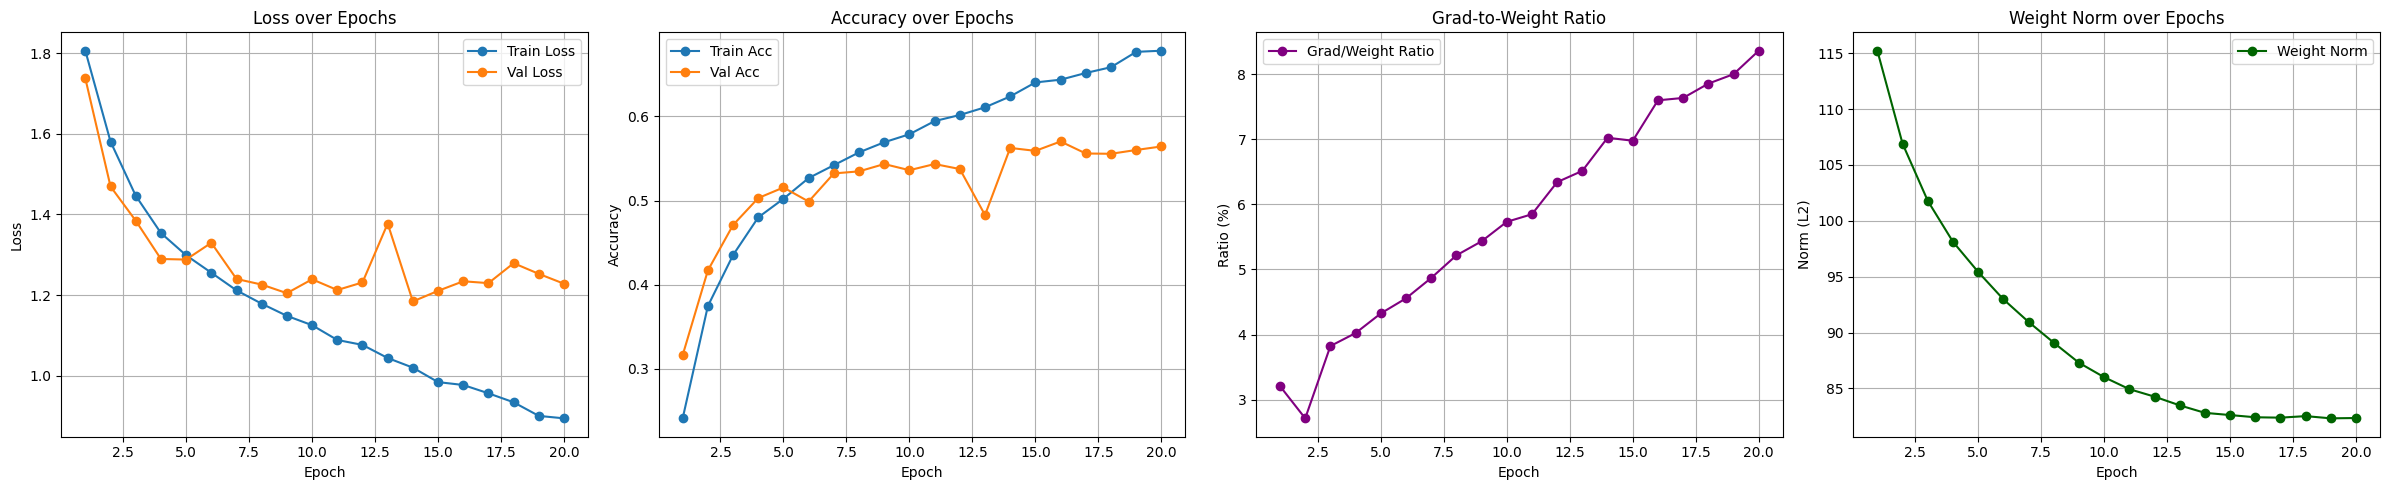

Test Accuracy: 0.5604
Test Loss: 1.2796

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       385
           1       0.89      0.16      0.28        49
           2       0.51      0.22      0.30       432
           3       0.70      0.84      0.76       705
           4       0.44      0.47      0.45       456
           5       0.79      0.60      0.68       331
           6       0.46      0.65      0.54       513

    accuracy                           0.56      2871
   macro avg       0.61      0.48      0.50      2871
weighted avg       0.57      0.56      0.55      2871


Confusion Matrix (subset):
[[174   0  16  49  54   7  85]
 [ 22   8   2   6   9   1   1]
 [ 65   1  93  44  97  31 101]
 [ 23   0   8 589  27   6  52]
 [ 60   0  20  44 213   4 115]
 [ 13   0  37  40  12 199  30]
 [ 29   0   7  65  74   5 333]]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 917ptwet with config:
wandb: 	batch_size: 256
wandb: 	conv_layers: [[1, 32, 7, 3, 2], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 3, 1, 1], [2, 2]]
wandb: 	dropout: 0.3973927890667316
wandb: 	learning_rate: 0.025019265650534177
wandb: 	weight_decay: 0.0026640341031452836


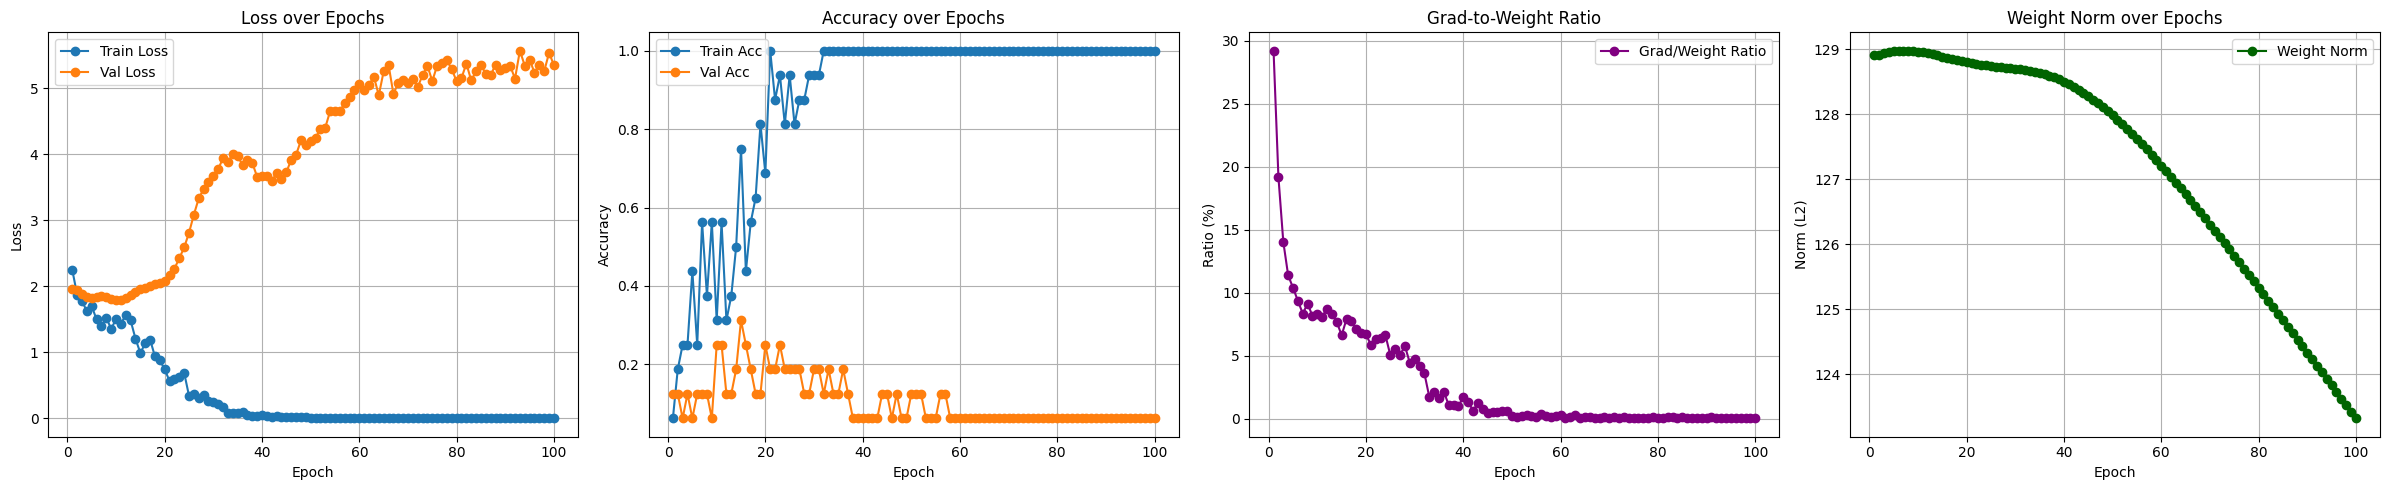


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

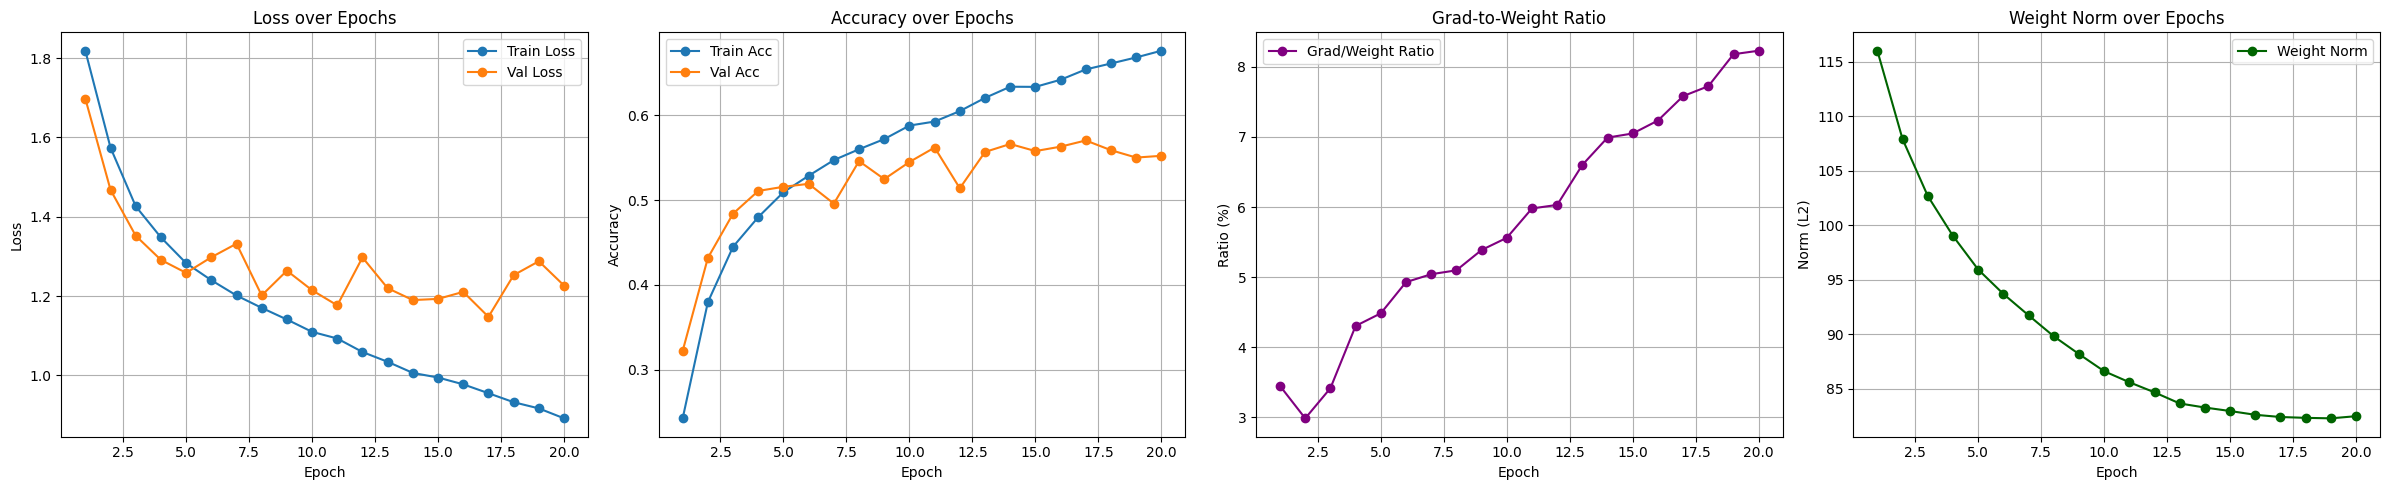

Test Accuracy: 0.5468
Test Loss: 1.2613

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       385
           1       0.62      0.10      0.18        49
           2       0.41      0.31      0.35       432
           3       0.78      0.75      0.76       705
           4       0.36      0.62      0.46       456
           5       0.77      0.64      0.70       331
           6       0.54      0.47      0.50       513

    accuracy                           0.55      2871
   macro avg       0.57      0.48      0.49      2871
weighted avg       0.57      0.55      0.55      2871


Confusion Matrix (subset):
[[171   1  34  26 100   9  44]
 [ 19   5   8   3  11   0   3]
 [ 41   0 133  29 144  35  50]
 [ 24   2  31 528  69  10  41]
 [ 53   0  43  21 282   3  54]
 [ 11   0  50  27  19 211  13]
 [ 43   0  29  45 151   5 240]]


wandb: Agent Starting Run: e4zmzm4b with config:
wandb: 	batch_size: 512
wandb: 	conv_layers: [[1, 32, 5, 2, 1], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 5, 2, 1], [2, 2]]
wandb: 	dropout: 0.46663116718532177
wandb: 	learning_rate: 0.05712290405816948
wandb: 	weight_decay: 0.007001920143825916


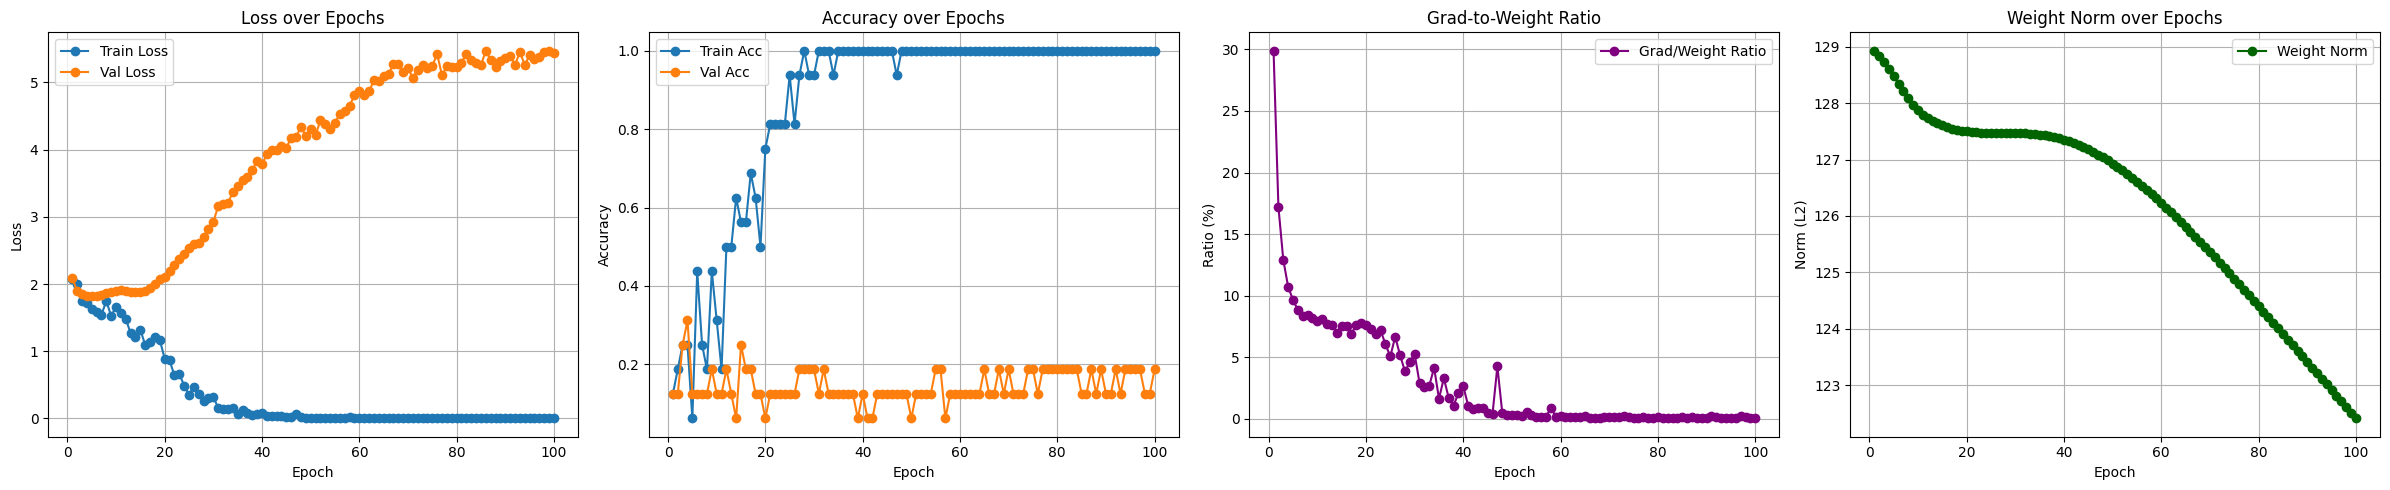


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

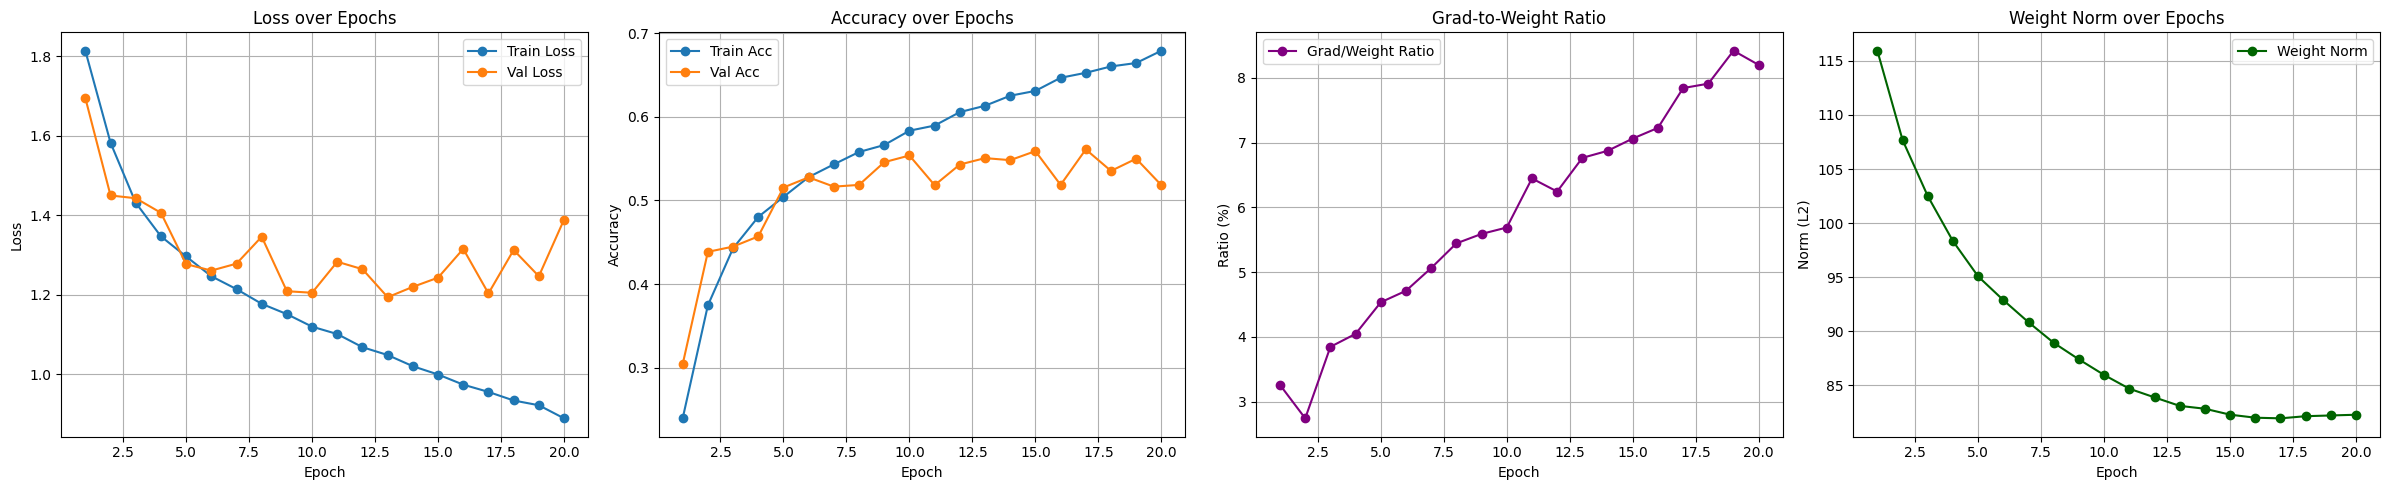

Test Accuracy: 0.5326
Test Loss: 1.4116

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       385
           1       0.39      0.27      0.32        49
           2       0.34      0.39      0.37       432
           3       0.67      0.84      0.75       705
           4       0.65      0.13      0.22       456
           5       0.53      0.84      0.65       331
           6       0.54      0.48      0.51       513

    accuracy                           0.53      2871
   macro avg       0.51      0.48      0.46      2871
weighted avg       0.54      0.53      0.50      2871


Confusion Matrix (subset):
[[167   6  65  55   7  32  53]
 [ 12  13  15   6   1   0   2]
 [ 39   7 170  51  13 105  47]
 [ 22   0  27 595   4  24  33]
 [ 94   3 126  69  60  33  71]
 [  9   0  14  25   0 277   6]
 [ 46   4  78  83   7  48 247]]


wandb: Agent Starting Run: swlcv0o4 with config:
wandb: 	batch_size: 128
wandb: 	conv_layers: [[1, 32, 7, 3, 2], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 3, 1, 1], [2, 2]]
wandb: 	dropout: 0.354531162180718
wandb: 	learning_rate: 0.07137066187007188
wandb: 	weight_decay: 0.0020979107037666337


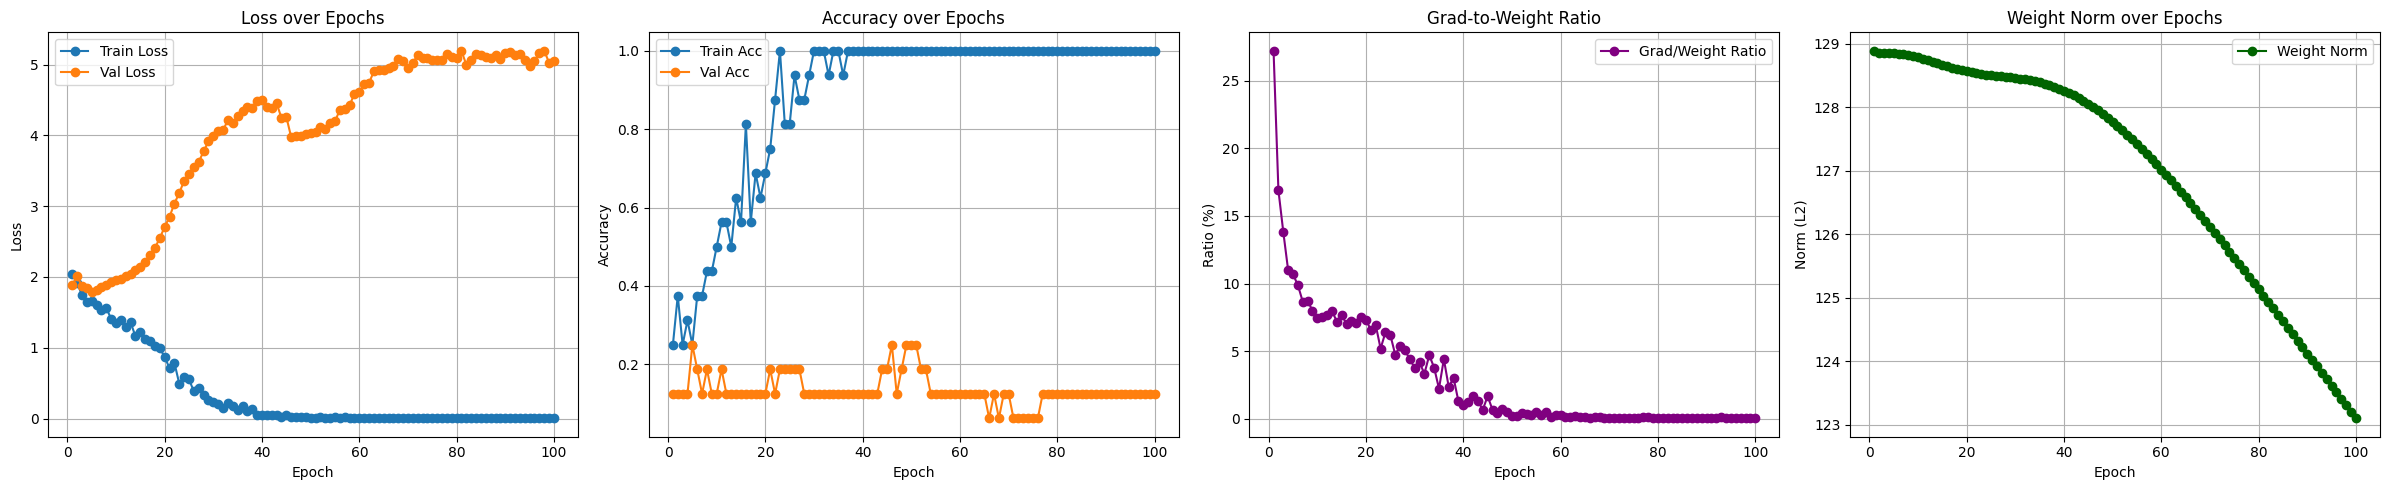


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

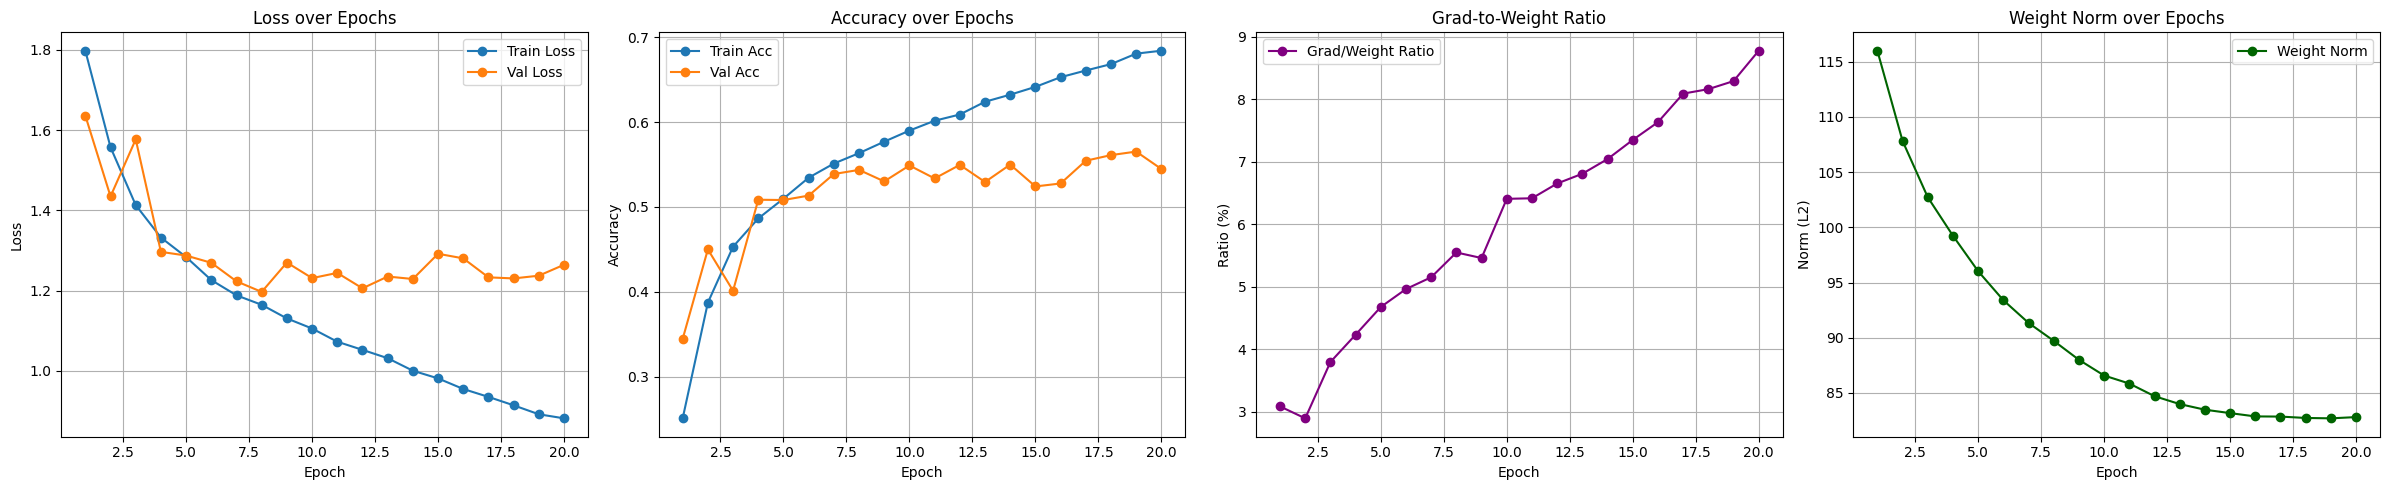

Test Accuracy: 0.5357
Test Loss: 1.3292

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.35      0.65      0.45       385
           1       0.71      0.10      0.18        49
           2       0.64      0.12      0.20       432
           3       0.73      0.79      0.76       705
           4       0.46      0.30      0.36       456
           5       0.75      0.68      0.71       331
           6       0.44      0.60      0.51       513

    accuracy                           0.54      2871
   macro avg       0.58      0.46      0.45      2871
weighted avg       0.57      0.54      0.51      2871


Confusion Matrix (subset):
[[249   0   4  30  25   9  68]
 [ 28   5   0   5   3   2   6]
 [127   1  52  47  57  45 103]
 [ 50   0   5 559  21   9  61]
 [142   1   6  36 137   4 130]
 [ 31   0  11  35   4 226  24]
 [ 87   0   3  55  50   8 310]]


wandb: Agent Starting Run: jjiuea73 with config:
wandb: 	batch_size: 512
wandb: 	conv_layers: [[1, 32, 5, 2, 1], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 5, 2, 1], [2, 2]]
wandb: 	dropout: 0.5743023498177731
wandb: 	learning_rate: 0.09882304007047708
wandb: 	weight_decay: 0.0041258505992886225


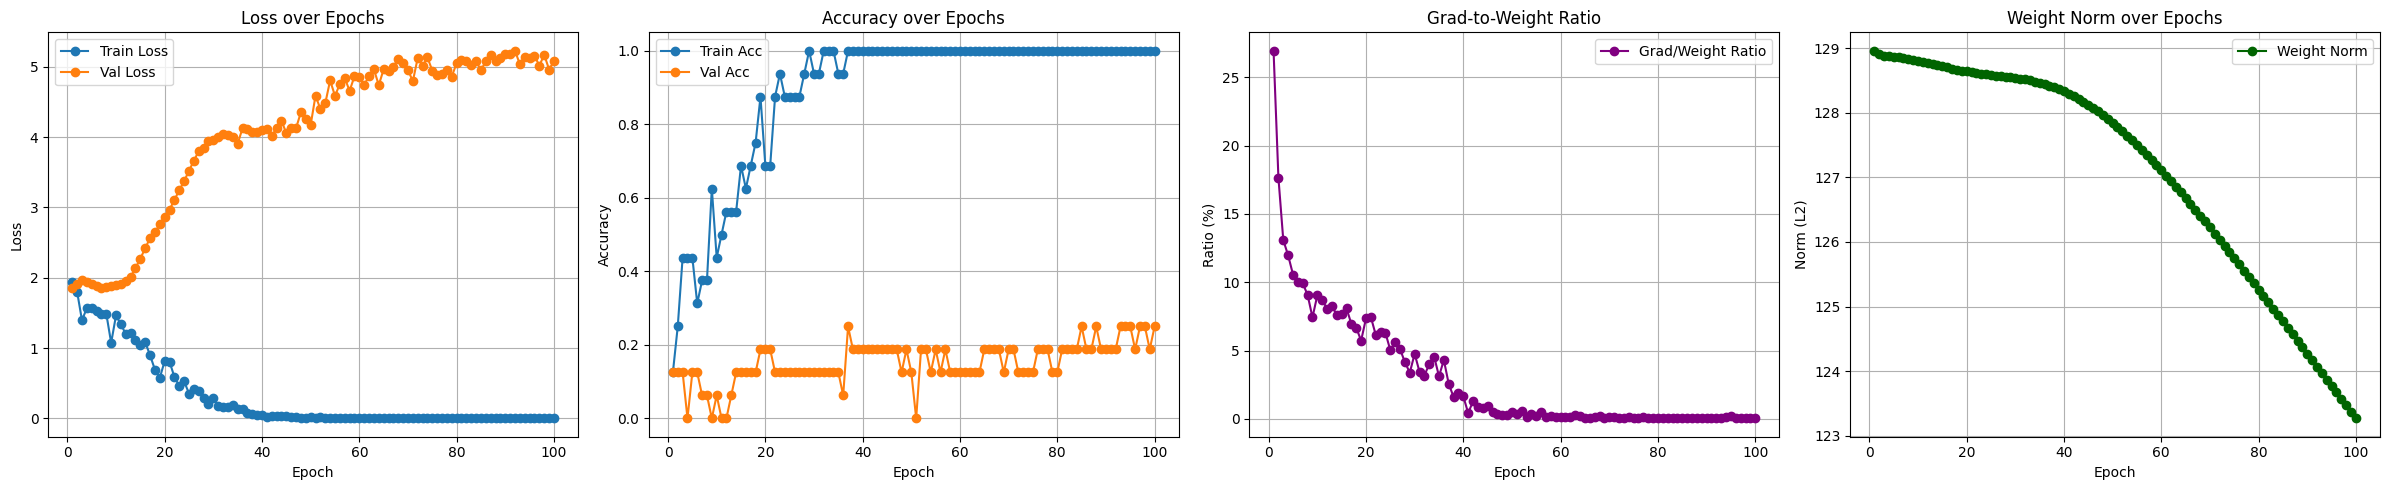


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

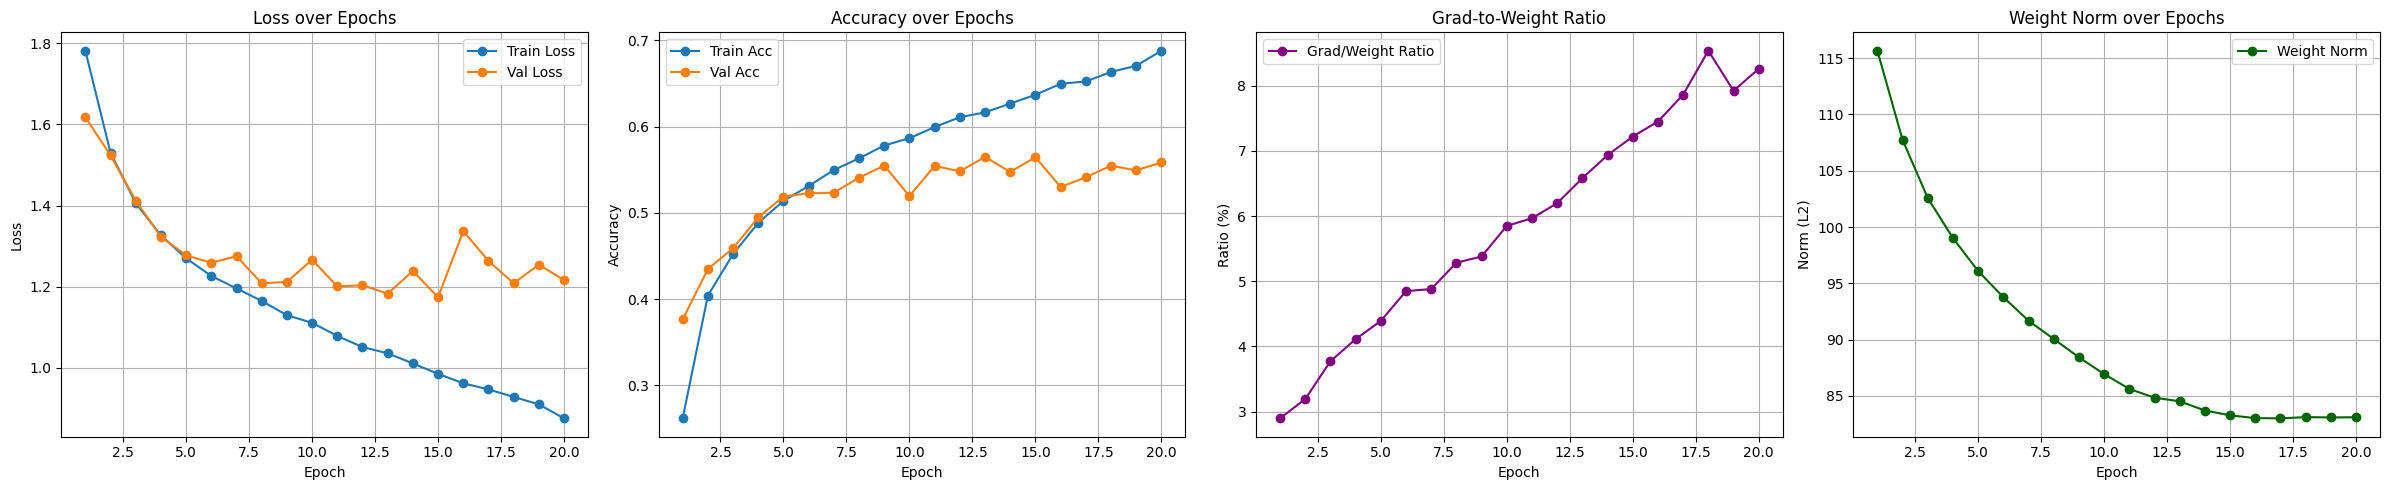

Test Accuracy: 0.5573
Test Loss: 1.2546

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.44      0.51      0.48       385
           1       1.00      0.10      0.19        49
           2       0.39      0.36      0.38       432
           3       0.81      0.75      0.78       705
           4       0.41      0.46      0.43       456
           5       0.73      0.66      0.69       331
           6       0.51      0.55      0.53       513

    accuracy                           0.56      2871
   macro avg       0.61      0.49      0.50      2871
weighted avg       0.57      0.56      0.56      2871


Confusion Matrix (subset):
[[198   0  42  24  55   7  59]
 [ 24   5  11   2   5   0   2]
 [ 61   0 157  20  94  41  59]
 [ 33   0  40 529  36  15  52]
 [ 71   0  53  29 209   8  86]
 [ 17   0  54  18  11 219  12]
 [ 44   0  44  33  99  10 283]]


wandb: Agent Starting Run: 608hqwfo with config:
wandb: 	batch_size: 128
wandb: 	conv_layers: [[1, 32, 5, 2, 1], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 5, 2, 1], [2, 2]]
wandb: 	dropout: 0.5009985795428715
wandb: 	learning_rate: 0.00980845266897851
wandb: 	weight_decay: 0.0068032706872064586


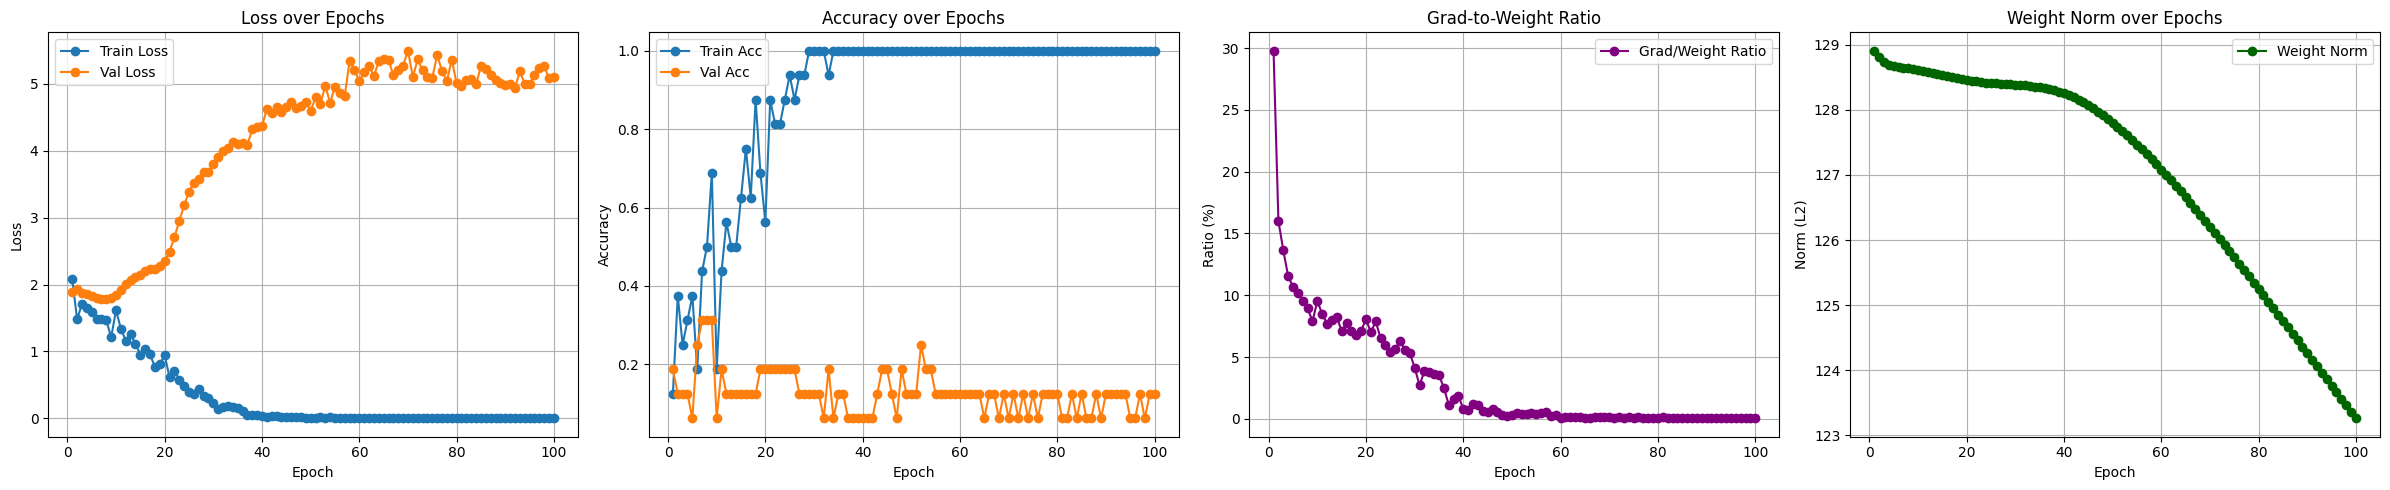


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

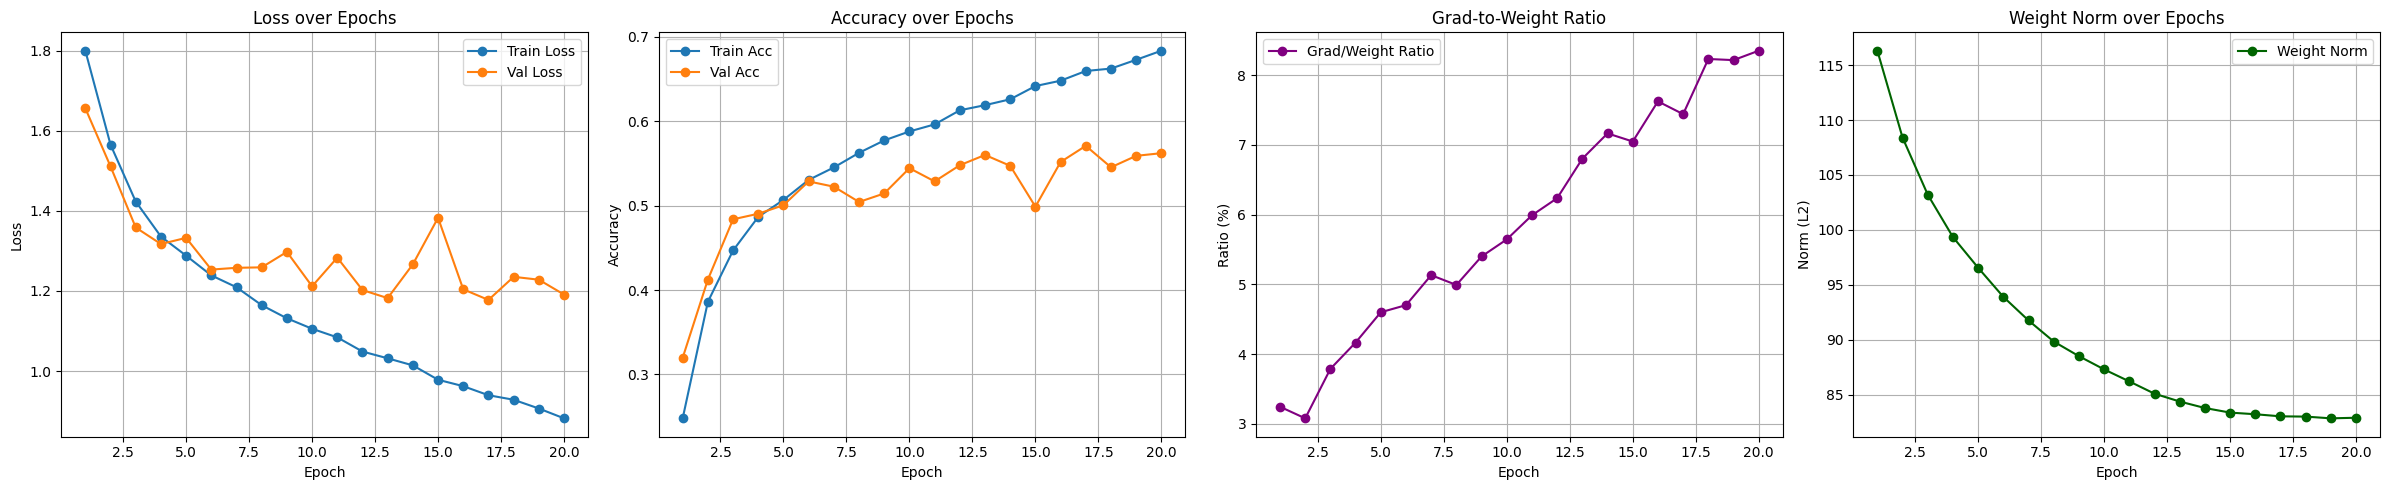

Test Accuracy: 0.5521
Test Loss: 1.2441

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       385
           1       1.00      0.06      0.12        49
           2       0.43      0.23      0.30       432
           3       0.81      0.73      0.77       705
           4       0.45      0.46      0.46       456
           5       0.68      0.70      0.69       331
           6       0.44      0.63      0.52       513

    accuracy                           0.55      2871
   macro avg       0.61      0.48      0.47      2871
weighted avg       0.57      0.55      0.54      2871


Confusion Matrix (subset):
[[200   0  29  29  38   7  82]
 [ 22   3   4   3   9   1   7]
 [ 60   0  98  18  91  74  91]
 [ 32   0  21 516  31  16  89]
 [ 76   0  32  22 211   6 109]
 [ 11   0  18  21  12 232  37]
 [ 52   0  26  31  72   7 325]]


wandb: Agent Starting Run: ao248cfr with config:
wandb: 	batch_size: 128
wandb: 	conv_layers: [[1, 32, 5, 2, 1], [2, 2], [32, 64, 5, 2, 1], [2, 2], [64, 128, 5, 2, 1], [2, 2]]
wandb: 	dropout: 0.3936786860284737
wandb: 	learning_rate: 0.06619046225123873
wandb: 	weight_decay: 0.00504693111826645


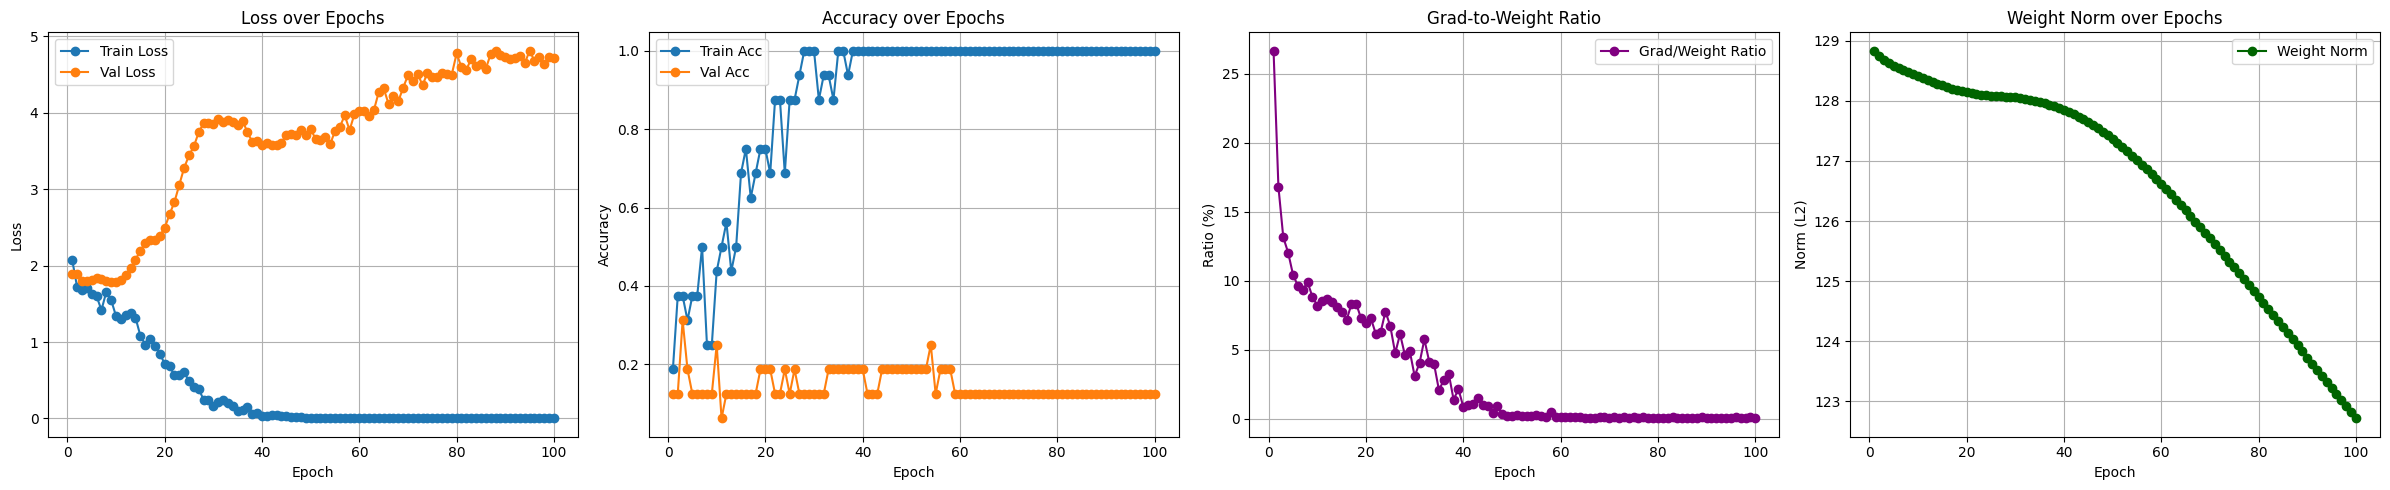


training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,600
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          51,264
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 6, 6]          73,856
      BatchNorm2d-10            [-1, 128, 6, 6]             256
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14        

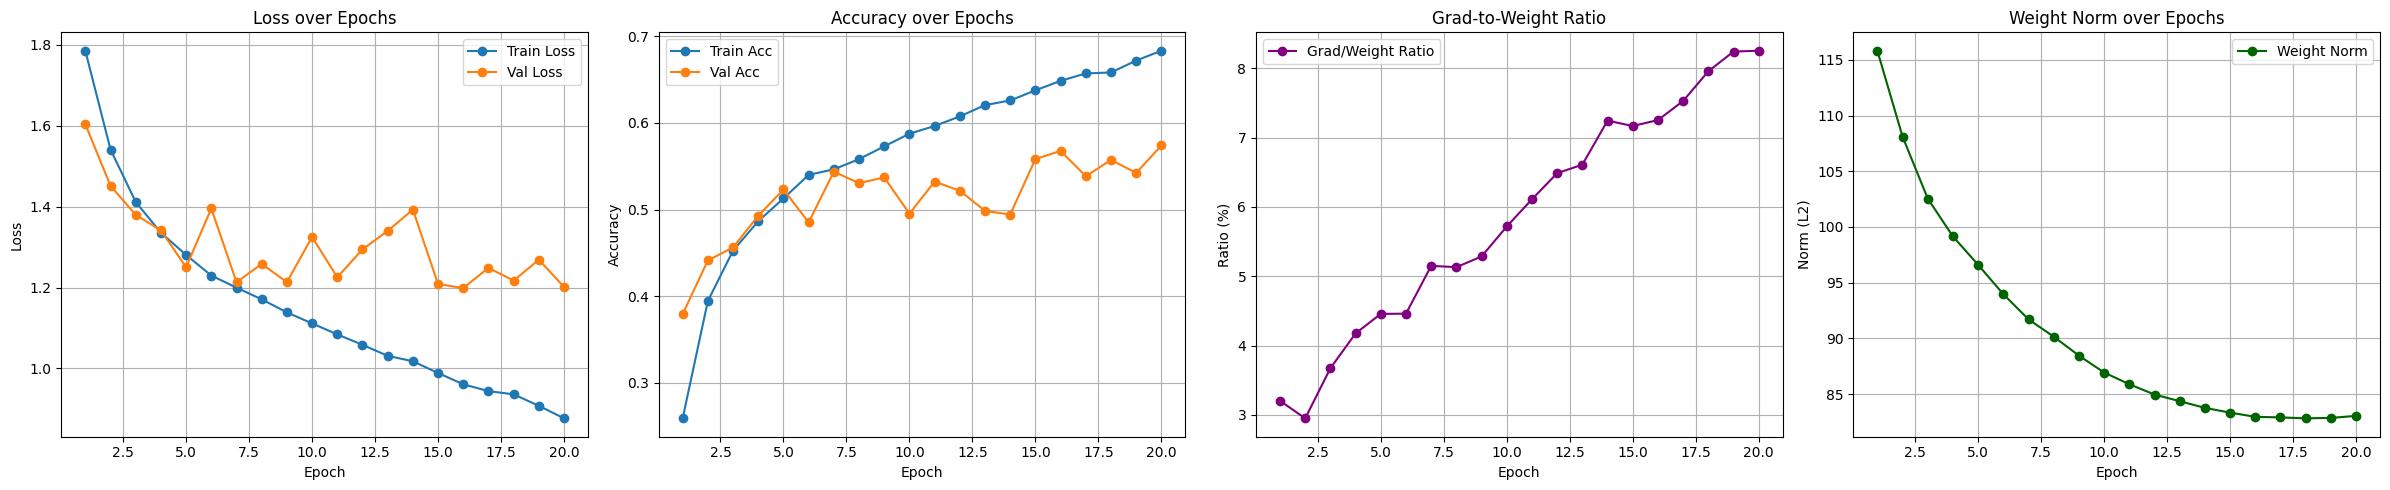

Test Accuracy: 0.5580
Test Loss: 1.2668

Classification Report (subset of classes present in test set):
              precision    recall  f1-score   support

           0       0.49      0.37      0.42       385
           1       0.90      0.18      0.31        49
           2       0.48      0.25      0.33       432
           3       0.79      0.76      0.77       705
           4       0.40      0.55      0.46       456
           5       0.66      0.73      0.69       331
           6       0.47      0.61      0.53       513

    accuracy                           0.56      2871
   macro avg       0.60      0.49      0.50      2871
weighted avg       0.57      0.56      0.55      2871


Confusion Matrix (subset):
[[143   0  26  34  79  15  88]
 [ 12   9  10   0  11   0   7]
 [ 42   0 110  29 107  65  79]
 [ 19   0   8 536  51  21  70]
 [ 47   1  37  23 250  10  88]
 [  7   0  22  22  21 242  17]
 [ 24   0  18  36 109  14 312]]


In [ ]:
import random
import time

sweep_config = {
    'method': 'random',  # or 'grid', 'bayes'
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1
        },
        'weight_decay': {
            'min': 0.0001,
            'max': 0.01
        },
        'batch_size': {
            'values': [128, 256, 512]
        },
        'dropout': {
            'min': 0.3,
            'max': 0.6
        },
        'conv_layers': {
            'values': [
                [
                  (1, 32, 7, 3, 2),
                  (2, 2),
                  (32, 64, 5, 2, 1),
                  (2, 2),
                  (64, 128, 3, 1, 1),
                  (2, 2),
                ],
                [
                  (1, 32, 5, 2, 1),
                  (2, 2),
                  (32, 64, 5, 2, 1),
                  (2, 2),
                  (64, 128, 5, 2, 1),
                  (2, 2),
                ]
            ]
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='emotion-recognition')

wandb.agent(sweep_id, function=wandb_run, count=10)